# 1. Imports

In [103]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb

import inflection
import datetime
import pickle
import warnings

from matplotlib            import pyplot as plt
from scipy                 import stats  as ss
from tabulate              import tabulate
from IPython.core.display  import HTML
from IPython.display       import Image
from boruta                import BorutaPy
from random                import sample
from flask                 import Flask 

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso


## 1.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")

    warnings.filterwarnings('ignore')


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[ 0 ]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = k - (r-1)**2/(n-1)

    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ))


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name':model_name,
                           'MAE': mae,  
                           'MAPE': mape, 
                           'RMSE': rmse}, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1, kfold + 1) ):
        if verbose:
            print(f'KFold Number: {k}')

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation ) 
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( 
        {'Model Name': model_name,
        'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + " +/- " + np.round( np.std( mae_list ), 2 ).astype( str ),
        'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + " +/- " + np.round( np.std( mape_list ), 2 ).astype( str ), 
        'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + " +/- " + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Gustavo Castro\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 1.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# check
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
84501,877,7,2015-05-17,0,0,0,0,0,0,a,c,29190.0,NaN,NaN,0,NaN,NaN,NaN
902060,811,7,2013-04-14,0,0,0,0,0,0,a,a,410.0,9.0,2012.0,0,NaN,NaN,NaN


# 2. Data Description

In [5]:
# Dataset copy
df1 = df_raw.copy()

## 2.1. Renaming Columns

In [6]:
# check the column names
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = df1.columns
snake_case = lambda x: inflection.underscore(x)
cols_new = list( map(snake_case, cols_old) )

# rename columns
df1.columns = cols_new

## 2.2. Data Dimensions

In [8]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number os columns: {df1.shape[1]}')

Number of Rows: 1017209
Number os columns: 18


## 2.3. Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
# changing date to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4. Check NA

In [11]:
df1.isna().sum().sort_values(ascending = False)

promo_interval                  508031
promo2_since_year               508031
promo2_since_week               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
day_of_week                          0
promo2                               0
assortment                           0
store                                0
school_holiday                       0
state_holiday                        0
promo                                0
open                                 0
customers                            0
sales                                0
date                                 0
store_type                           0
dtype: int64

## 2.5. Fillout NA

* **competition_distance**  
    - Distance in meters to nearest competitor store.
    - If value is null, it means there are no near competitors.
    - Column filled with a value that is much higher than the maximum competition_distance in the dataset.

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
df1['competition_distance'].fillna(200000, inplace = True)

* **competition_open_since_year** and **competition_open_since_month**
    - Approximately the year and month the nearest competitor was opened.
    - Column filled with the year and month from the "date" column.

In [14]:
df1['competition_open_since_year'].fillna( df1['date'].dt.year, inplace = True)
df1['competition_open_since_month'].fillna( df1['date'].dt.month, inplace = True)

* **promo2_since_year** and **promo2_since_week**
    - Year and calendar week when the store started participating in promo2.
    - Column filled with the year and corresponding calendar week from the "date" column.

In [15]:
df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)
df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week, inplace = True)

* **promo_interval**
    - Consecutive intervals Promo2 is started, naming the months the promotion started.
    - Column filled with zeros.
    - New column "is_promo" created to indicates if there was a promo in the store that date. (1: Store was in promo / 0: Store was not in promo)

In [16]:
df1['promo_interval'].fillna(0, inplace = True)

# month map to help the operation
month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 
 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else (1 if x['month_map'] in x['promo_interval'].split( "," ) else 0), axis = 1)

In [17]:
# check for NA values again
df1.isna().sum().sort_values(ascending = False)

store                           0
day_of_week                     0
month_map                       0
promo_interval                  0
promo2_since_year               0
promo2_since_week               0
promo2                          0
competition_open_since_year     0
competition_open_since_month    0
competition_distance            0
assortment                      0
store_type                      0
school_holiday                  0
state_holiday                   0
promo                           0
open                            0
customers                       0
sales                           0
date                            0
is_promo                        0
dtype: int64

## 2.6. Change Data Types

In [18]:
# competition data to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

# promo data to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 2.7. Descriptive Statistics

The metrics are divided by attribute types: Numerical and Categorical

In [19]:
# dataset with only numerical attributes
num_attributes = df1.select_dtypes(include = [ int , 'float64'])

# dataset with only categorical attributes
cat_attributes = df1.select_dtypes(exclude = [ int , 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

Some of the metrics to look at are as follows:

* **Central tendency**
    - mean
    - median
* **Dispersion**
    - minimum (min)
    - maximum (max)
    - range
    - standard deviation (std)
    - skew
    - kurtosis

In [20]:
# Central Tendency
_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
_min = pd.DataFrame(num_attributes.apply(min)).T
_max = pd.DataFrame(num_attributes.apply(max)).T
_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
_std = pd.DataFrame(num_attributes.apply(np.std)).T
_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
summary = pd.concat([_min, _max, _range, _mean, _median, _std, _skew, _kurtosis]).T.reset_index()
summary.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


* **Sales Analysis** 
    - The **"min = 0"** indicates there were days with no sales (store was closed).
    - The **"max = 41551"** indicates there were a maximum of 41551 sales per day.
    - The **"mean = 5773"** indicates there were on average 5773 sales per day.
    - The **"median = 5774"** is close to the mean, it indicates there aren't a lof of skewed data.
    - The **"std = 3849** indicates that for most days the number of sales is in the range 5773 +/\- 3849.
    - The **"skew = 0.641460**" indicates a slightly deslocation of the sales distribution to the left.
    - The **"kurtosis = 1.778375**" indicates the distribution has a slightly higher peak than a normal distribution.

* **Sales Plot** 

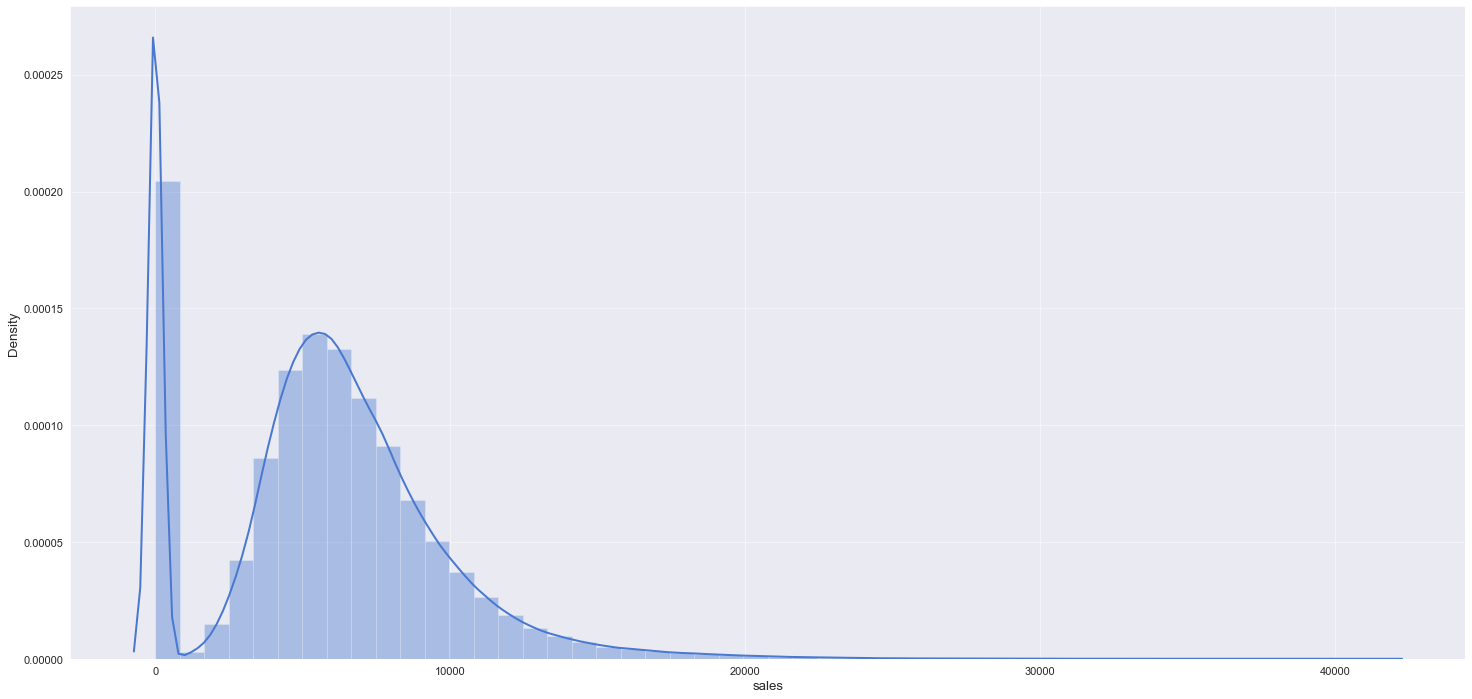

In [21]:
# plots distribution
sns.distplot(df1['sales'])
plt.show()

### 2.7.2. Categorical Attributes

We can get the number of sales for each unique values of these features.

In [22]:
# Qtd. of unique attributes per feature
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

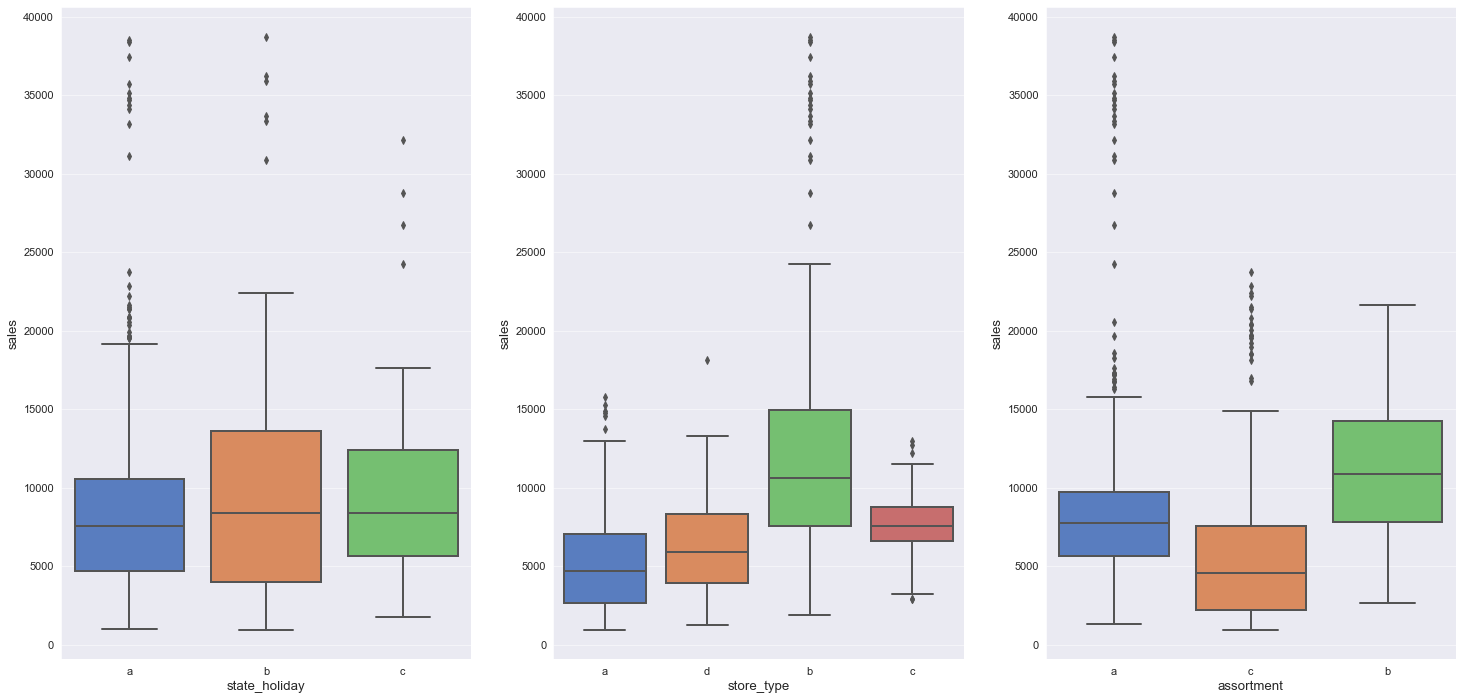

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig, axes = plt.subplots(1, 3)

_ = sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1, ax = axes[0])
_ = sns.boxplot(x = 'store_type', y = 'sales', data = aux1, ax = axes[1])
_ = sns.boxplot(x = 'assortment', y = 'sales', data = aux1, ax = axes[2])

plt.show()

# 3. Featuring Engineering

We have to understand the phenomenon that is being modeled and it's agents.

* **Phenomenon:** Sales
* **Agents:** Clients
    - Described by: Age, Sex, Job, ... 

## 3.1. Mind Map

![mindmap.png](img/MindmapHyphotesis.png)

## 3.2. Creating Hypothesis

Creating hypothesis for the variables that could have some influence in the phenomenon. 

### 3.2.1 Store's Hypothesis 

**1.**  Stores with more employees should sell more.

**2.**  Stores with more stock should should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with more assortment should sell more.

**5.** Stores with nearer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 3.2.2. Product's Hypothesis

**1.** Stores with more investment in marketing should sell more.

**2.** Stores with more products exposed should sell more.

**3.** Stores with lower prices should sell more.

**4.** Stores with bigger promotions should sell more.

**5.** Stores with lower prices for longer periods should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 3.2.3. Time's Hypothesis

**1.** Stores opened during Christmas should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second semester of the year.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 3.3. Main Hypothesis List

These hypotheses were chosed based on the available data.

**1.** Stores with more assortment should sell more.

**2.** Stores with nearer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with lower prices for longer periods should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores opened during Christmas should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second semester of the year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 3.4. Creating New Features

New features are created to help with the Exploratory Data Analysis (EDA).

In [24]:
# Dataset copy
df2 = df1.copy()

* **Calendar**

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month 
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# check
df2[['date', 'year', 'month', 'week_of_year', 'year_week']].sample(2)

,date,year,month,week_of_year,year_week
821903,2013-06-25,2013,6,26,2013-25
578768,2014-01-29,2014,1,5,2014-04


* **Competition**

In [26]:
# competition since
df2['competition_since'] = df2.apply(lambda x: 
    datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)

# competition time month
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( int )

# check
df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(2)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
125157,2015-04-10,2010,2,2010-02-01,63
647311,2013-11-28,2010,12,2010-12-01,36


* **Promo**

In [27]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

# promo time week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# check 
df2[['date', 'promo2_since_year', 'promo2_since_week', 'promo_since', 'promo_time_week']].sample(2)

,date,promo2_since_year,promo2_since_week,promo_since,promo_time_week
316226,2014-10-07,2014,41,2014-10-06,0
909478,2013-04-07,2011,40,2011-09-26,79


* **Assortment**

In [28]:
assortment = {'a' : 'basic', 'b' : 'extra', 'c' : 'extended'}

# assortment
df2['assortment'] = df2['assortment'].map(assortment)

* **Holyday**

In [29]:
state_holiday = {'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'}

# state holiday
df2['state_holiday'] = df2['state_holiday'].map(state_holiday)

# 4. Data Filtering

Filtering the data is associetad to business restrictions.

In [30]:
# Dataset copy
df3 = df2.copy()

## 4.1. Rows Filtering

Rows indicating closed stores and stores with zero salles doesn't provide relevant information. They have to be removed.  

In [31]:
df3 = df3[ (df3["open"] != 0) & (df3["sales"] > 0) ]

## 4.2. Columns Selection

The columns to be removed are as follows:

* **customers:** This information would have to be predicted as well, so it is not available at the prediction time.

* **open:** It only has one's due to the rows filter.

* **promo_interval** and **month_map:** Their information were replaced by "is_promo" column.

In [32]:
df3.drop( columns = ['customers', 'open', 'promo_interval', 'month_map'], axis = 1, inplace = True )

#check
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 5. Exploratory Data Analysis (EDA)

The main 3 goals with EDA are as follows:

**1.** Gain business experience.

**2.** Validate the business hypothesis. (Insights)

**3.** Realize wich features are important to the model.

In [33]:
df4 = df3.copy()

## 5.1. Univariate Analysis

* **For example:** 'min', 'max', 'std' and 'range'.

### 5.1.1 Response Variable

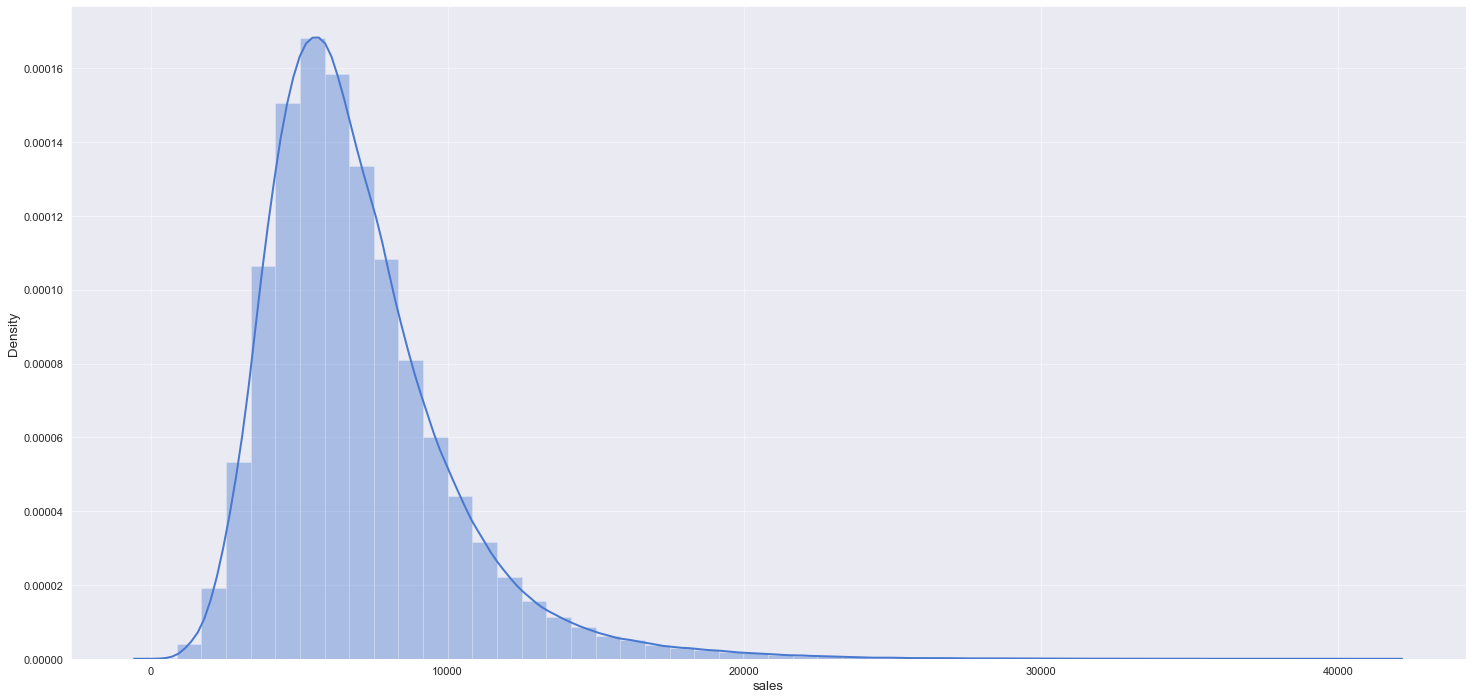

In [34]:
sns.distplot(df4['sales']);

Most machine learning algorithms perform better with normal distributions. So it's imporant to analyze the distribution to get some metrics like skew and kurtosis.

### 5.1.2 Numerical Variable

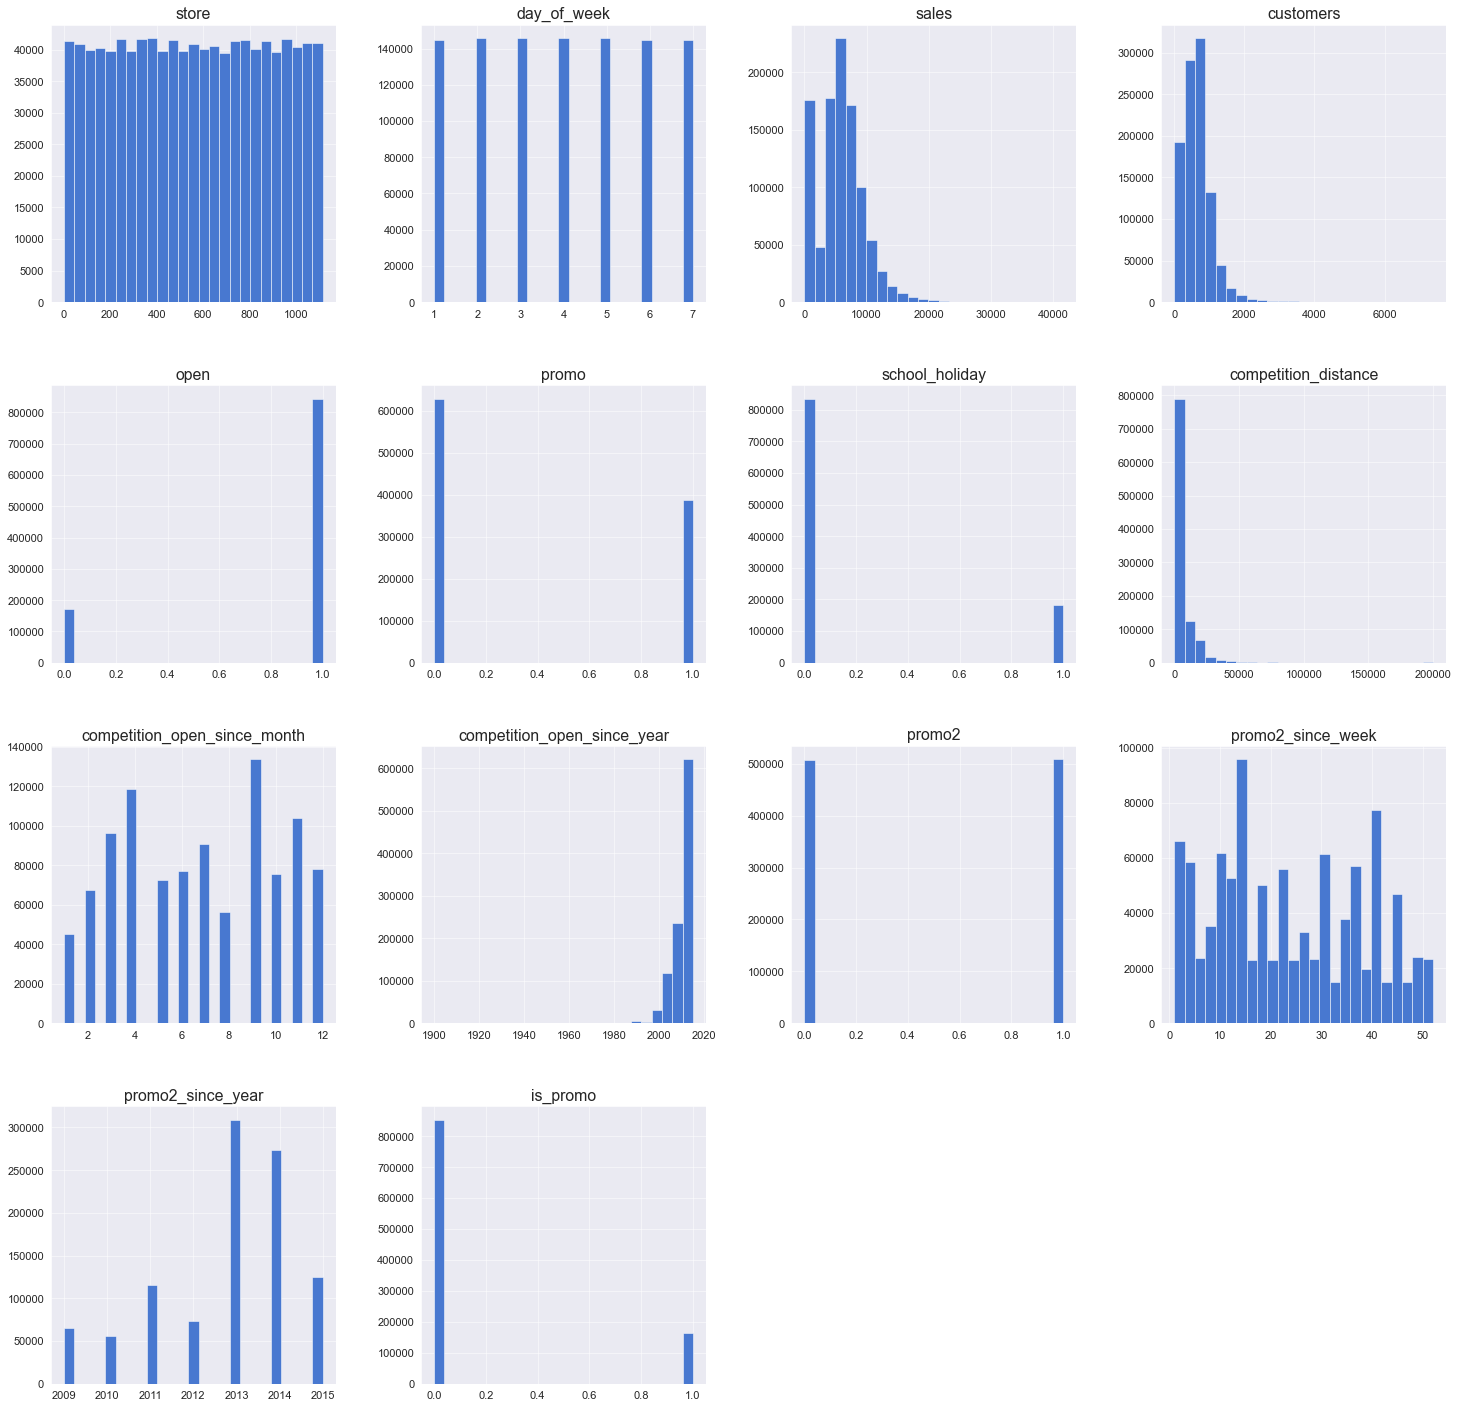

In [35]:
num_attributes.hist(bins = 25, figsize = (25, 25));

### 5.1.3. Categorical Variable

In [36]:
df4.select_dtypes(include = 'object').columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

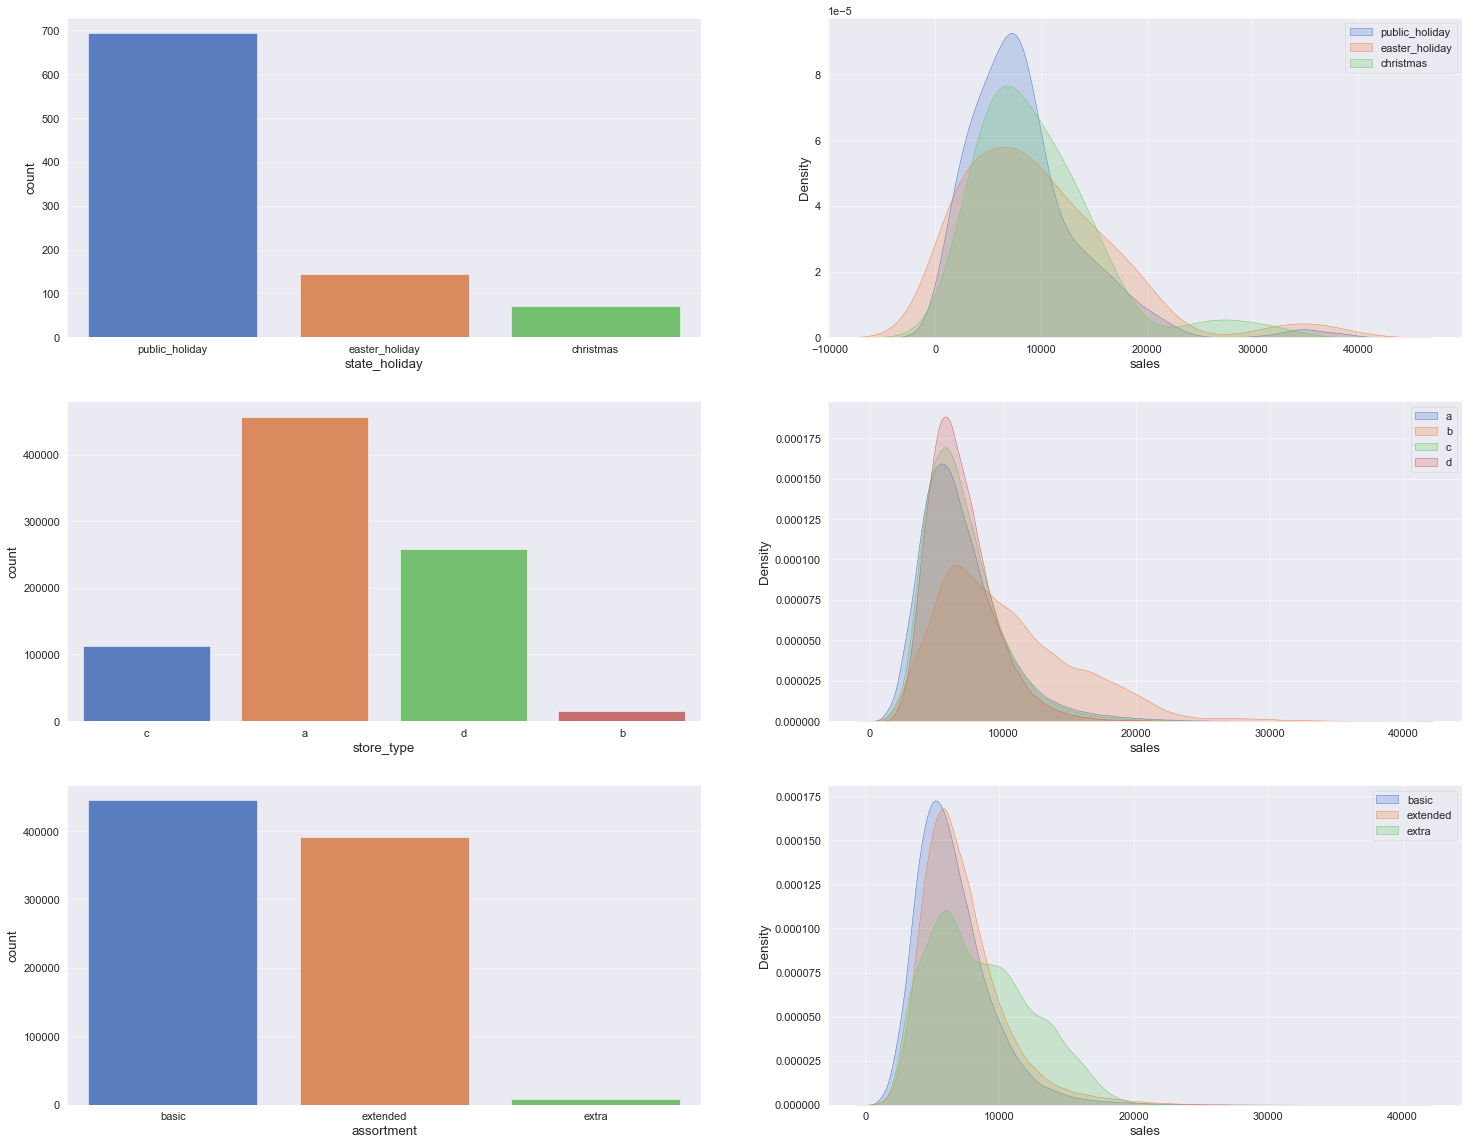

In [37]:
fig, axes = plt.subplots(3, 2, figsize  = (25,20))

#state_holiday
df_st = df4[df4['state_holiday'] != 'regular_day']

sns.countplot(x = df_st['state_holiday'], ax = axes[0][0])

sns.kdeplot(x = df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday',shade = True, ax = axes[0][1])
sns.kdeplot(x = df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday',shade = True, ax = axes[0][1])
sns.kdeplot(x = df4[df4['state_holiday'] == 'christmas']['sales'],label = 'christmas',shade = True, ax = axes[0][1])

#store_type
sns.countplot(x = df4['store_type'], ax = axes[1][0])

sns.kdeplot(x = df4[df4['store_type'] == 'a']['sales'],label = 'a',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'b']['sales'],label = 'b',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'c']['sales'],label = 'c',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'd']['sales'],label = 'd',shade = True, ax = axes[1][1])

#assortment
sns.countplot(x = df4['assortment'], ax = axes[2][0])

sns.kdeplot(x = df4[df4['assortment'] == 'basic']['sales'], label  = 'basic', shade = True, ax = axes[2][1])
sns.kdeplot(x = df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True, ax = axes[2][1])
sns.kdeplot(x = df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True, ax = axes[2][1])

# legends and plot
axes[0][1].legend()
axes[1][1].legend()
axes[2][1].legend()
plt.show()

## 5.2. Bivariate Analysis

* **For example:** Correlation and Hypothesis verification.

### H1. Stores with more assortment should sell more.
* **FALSE** - Stores with less assortment sell **less**.

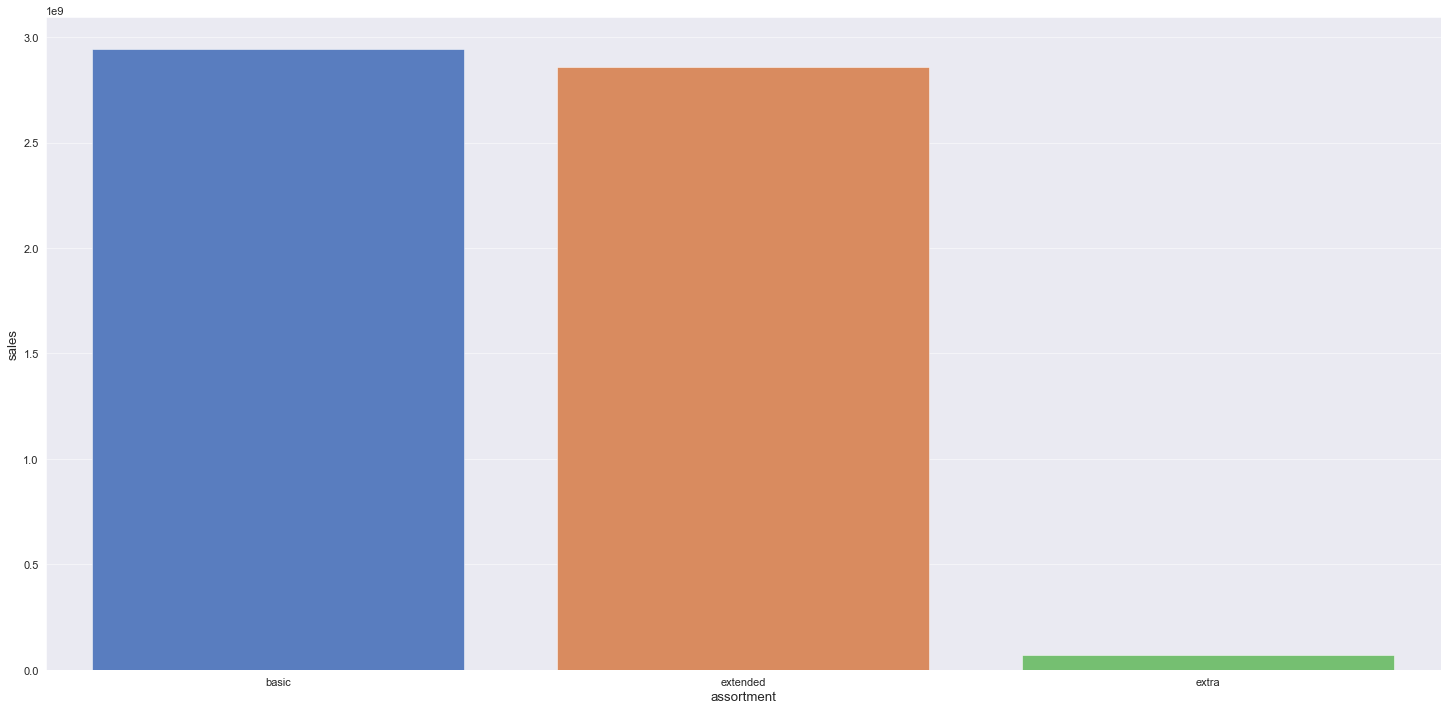

In [38]:
# plot sales for each assortment
df_aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x = 'assortment', y = 'sales', data = df_aux1 );

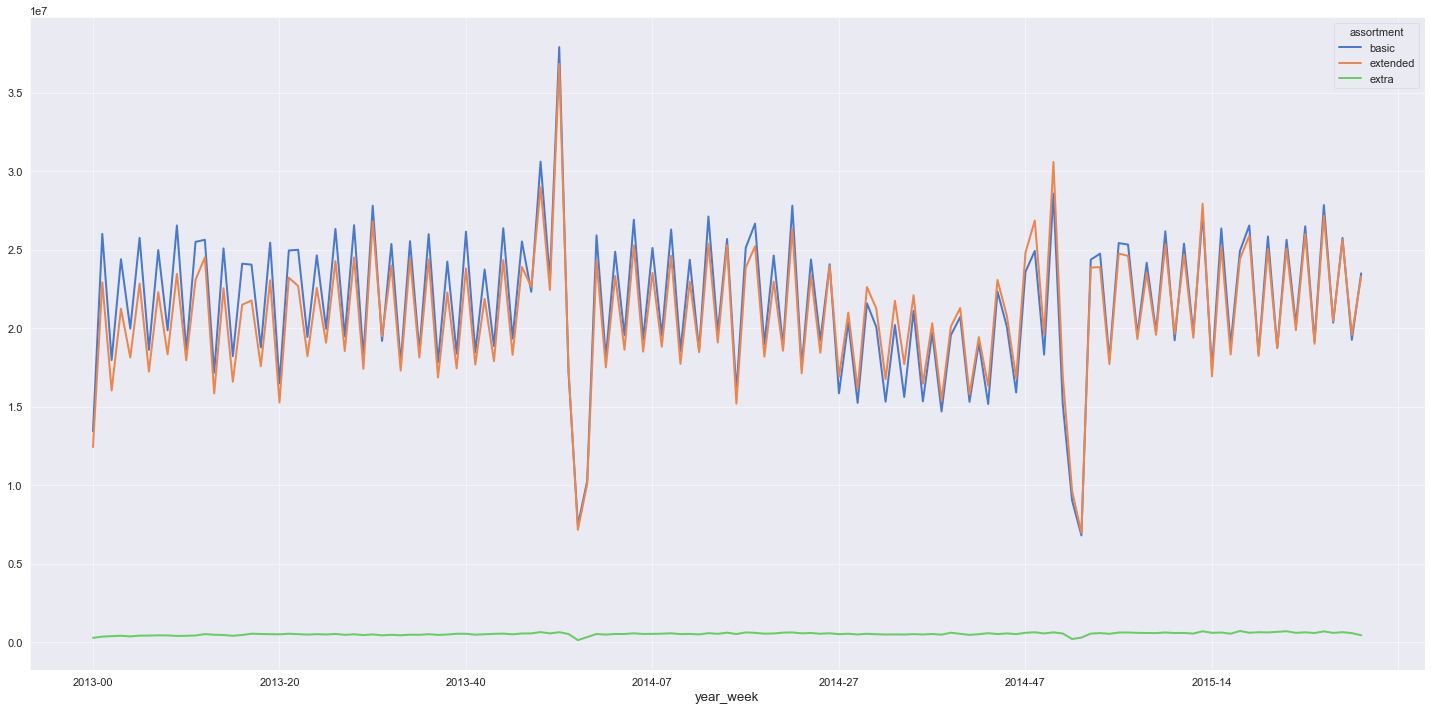

In [39]:
# plot sales for each assortment per week_year 
df_aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
df_aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot();

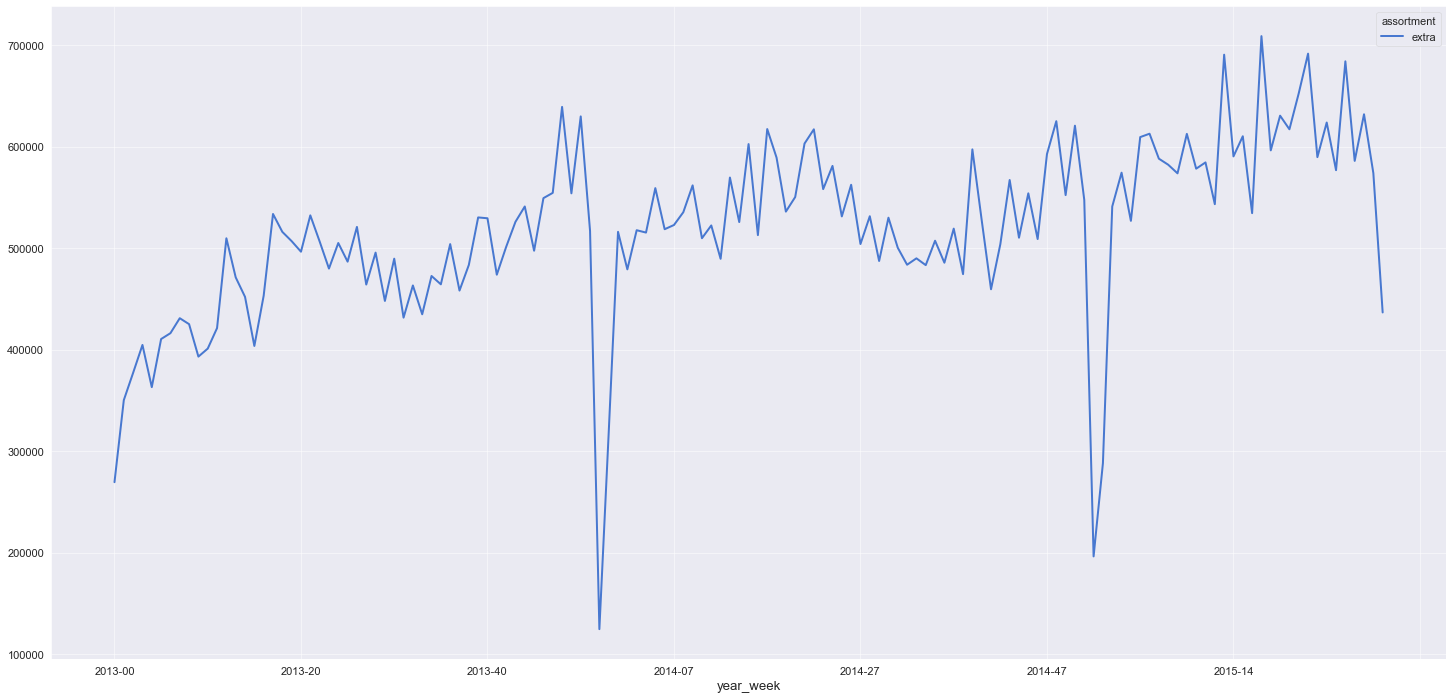

In [40]:
# plot sales for extra assortment per week_year 
df_aux3 = df_aux2[ df_aux2['assortment'] == 'extra' ]
df_aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot();

### H2. Stores with nearer competitors should sell less.
* **FALSE** - Stores with nearer competitors sell **more**.

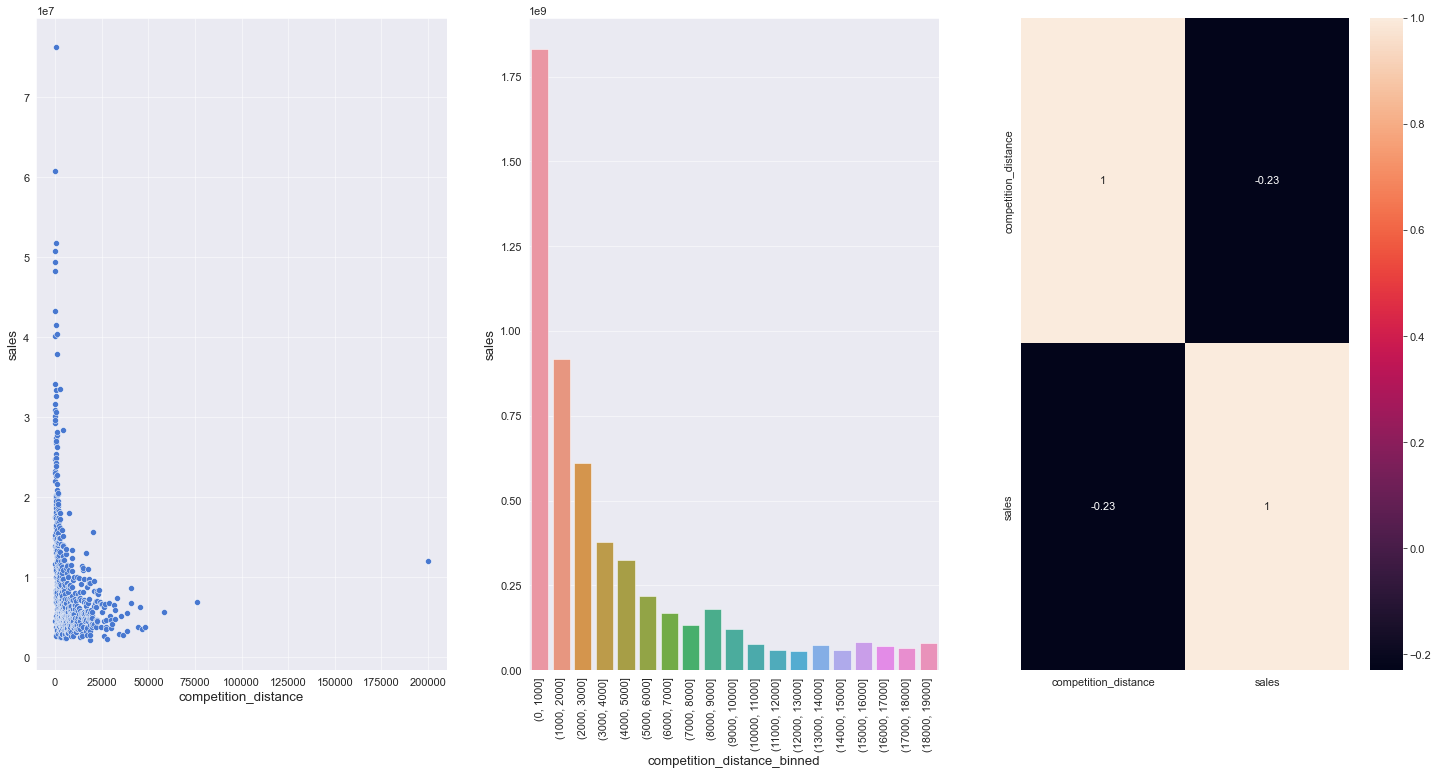

In [41]:
df_aux1 = df4[['competition_distance', 'sales']].groupby( ['competition_distance'] ).sum().reset_index()

# scatter plot of sales per competition distance
plt.subplot(1,3,1)
sns.scatterplot( x = 'competition_distance', y = 'sales', data = df_aux1 )

# bar plot of sales per ranges of competition distance
plt.subplot(1,3,2)
bins = list( np.arange(0, 20000, 1000) )
df_aux1['competition_distance_binned'] = pd.cut( df_aux1['competition_distance'], bins = bins )
df_aux2 = df_aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

sns.barplot( x = 'competition_distance_binned', y = 'sales', data = df_aux2 )
plt.xticks(rotation = 90)

# strength of the correlation between sales and competition_distance
plt.subplot(1,3,3)
sns.heatmap( df_aux1.corr( method = 'pearson' ), annot = True );


### H3. Stores with longer competitors should sell more.
* **FALSE** -  Stores with longer competitors sell **less**.

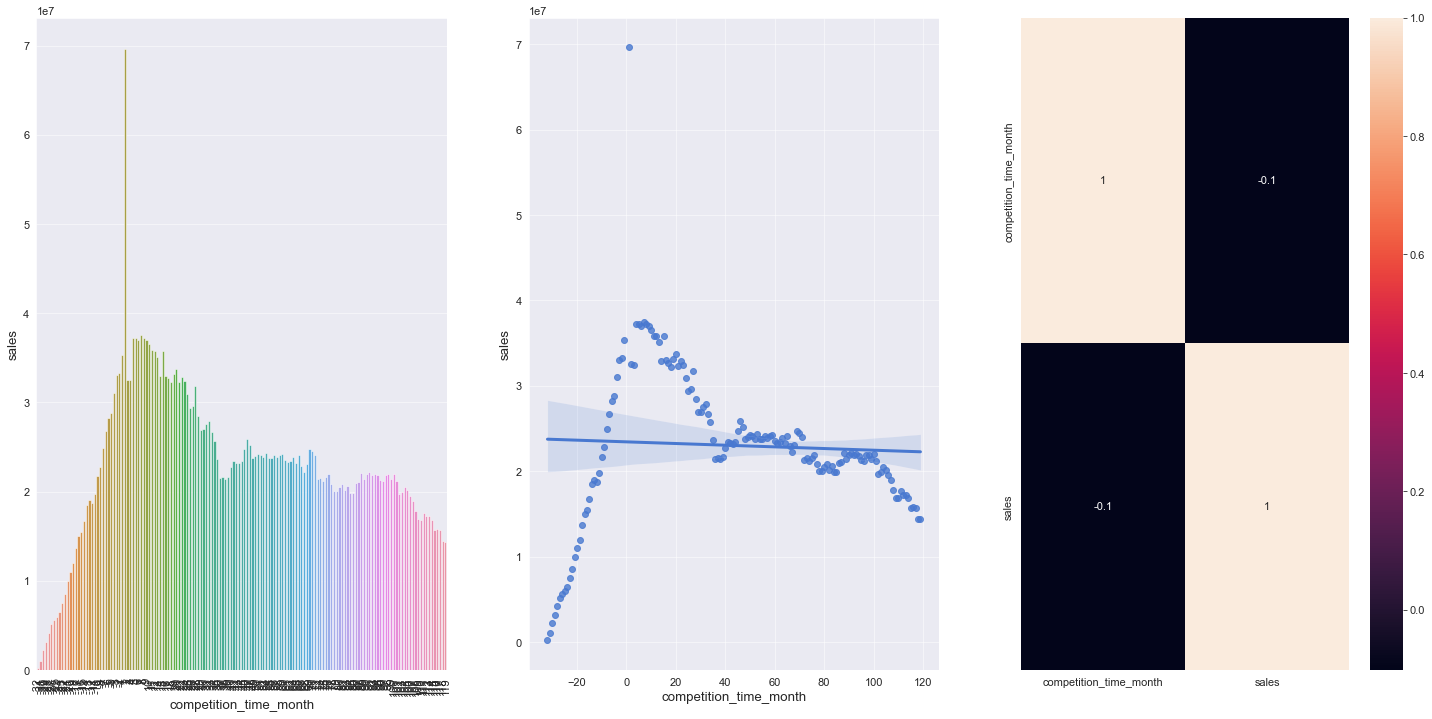

In [42]:
# bar plot of sales per ranges of competition_time_month
plt.subplot(1,3,1)
df_aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
df_aux2 = df_aux1[(df_aux1['competition_time_month'] < 120) & (df_aux1['competition_time_month'] != 0)]

sns.barplot( x = 'competition_time_month', y = 'sales', data = df_aux2)
plt.xticks(rotation = 90);

# reg plot of sales per competition_time_month
plt.subplot(1,3,2)
sns.regplot( x = 'competition_time_month', y = 'sales', data = df_aux2 );

# strength of the correlation between sales and competition_time_month
plt.subplot(1,3,3)
sns.heatmap(df_aux1.corr( method = 'pearson' ), annot = True);

### H4. Stores with lower prices for longer periods should sell more.
* **FALSE** - Stores with lower prices for longer periods sell **less after some period**.

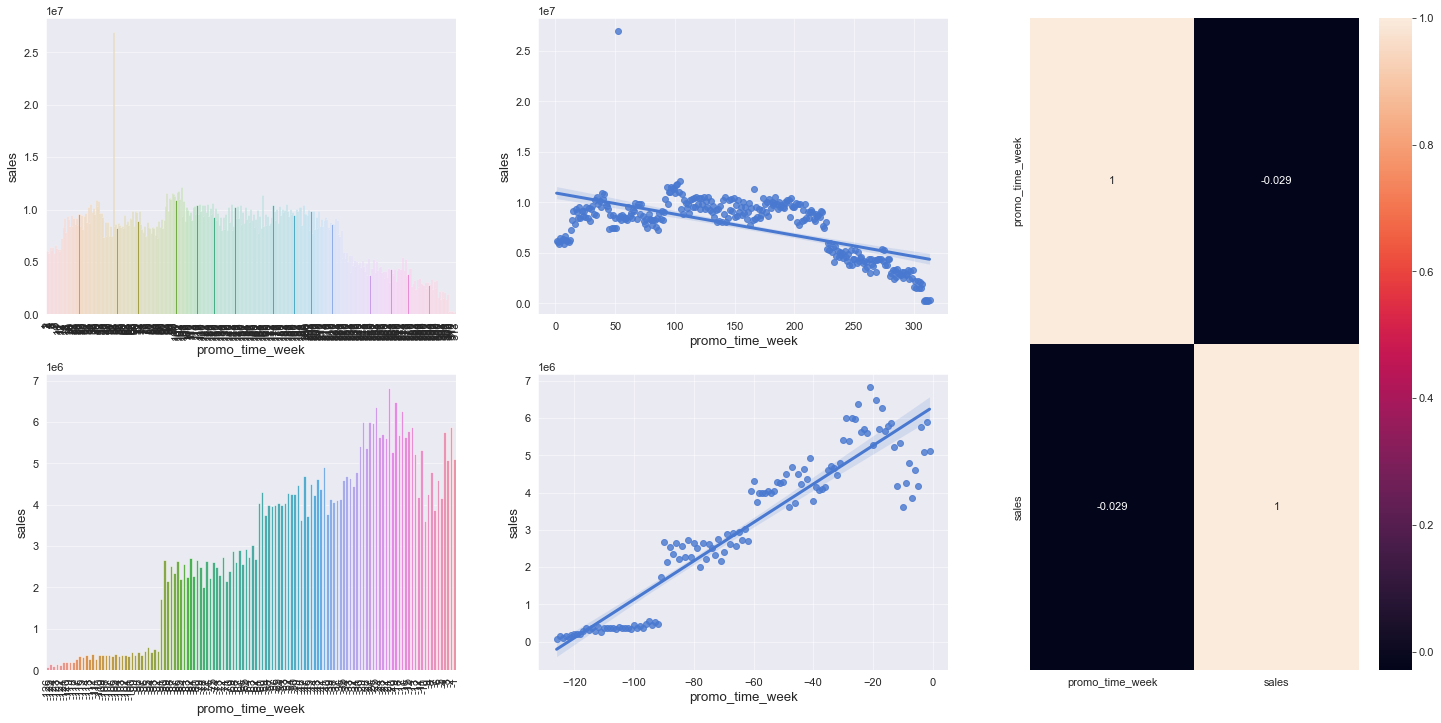

In [43]:
df_aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2, 3)

# bar plot of sales per extended promo period 
plt.subplot( grid[0, 0] )
df_aux2 = df_aux1[df_aux1['promo_time_week'] > 0]
sns.barplot( x = 'promo_time_week', y = 'sales', data = df_aux2 )
plt.xticks( rotation = 90);

# reg plot of sales per extended promo period 
plt.subplot( grid[0, 1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = df_aux2 )

# bar plot of sales per regular promo period 
plt.subplot( grid[1, 0] )
df_aux3 = df_aux1[df_aux1['promo_time_week'] < 0]
sns.barplot( x = 'promo_time_week', y = 'sales', data = df_aux3 )
plt.xticks( rotation = 90);

# reg plot of sales per regular promo period 
plt.subplot( grid[1, 1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = df_aux3 )

# strength of the correlation between sales and promo_time_week
plt.subplot( grid[:, 2] )
sns.heatmap( df_aux1.corr( method = 'pearson' ), annot = True );

### <s>H5. Stores with more promotion days should sell more.</s>

### H6. Stores with more consecutive promotions should sell more.
* **FALSE** - Stores with more consecutive promotions sell **less**.

In [44]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


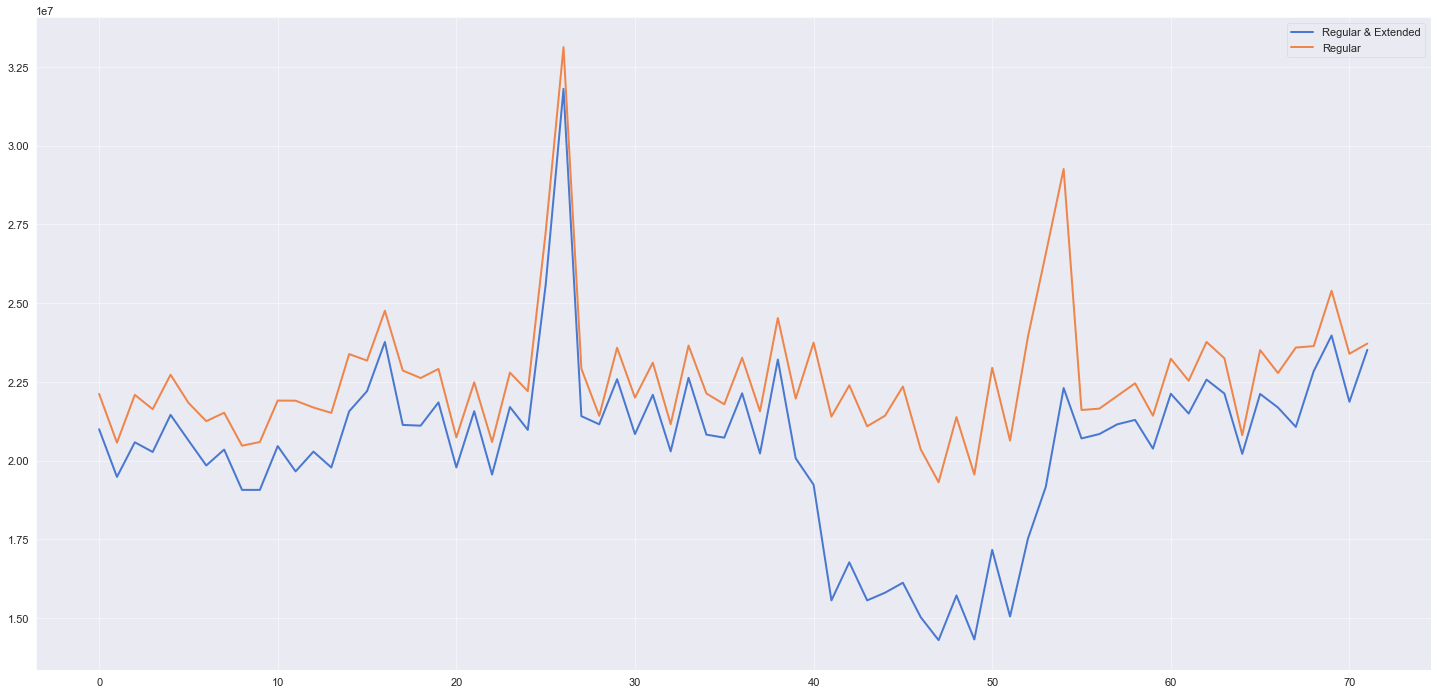

In [45]:
# line plot of sales per year_week with regular and extended promo
df_aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = df_aux1.plot()

# line plot of sales per year_week with regular promo
df_aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
df_aux2.plot( ax = ax )

ax.legend( labels = ['Regular & Extended', 'Regular'] );

### H7. Stores opened during Christmas should sell more.
* **FALSE** - Stores opened during Christmas sell **less**.

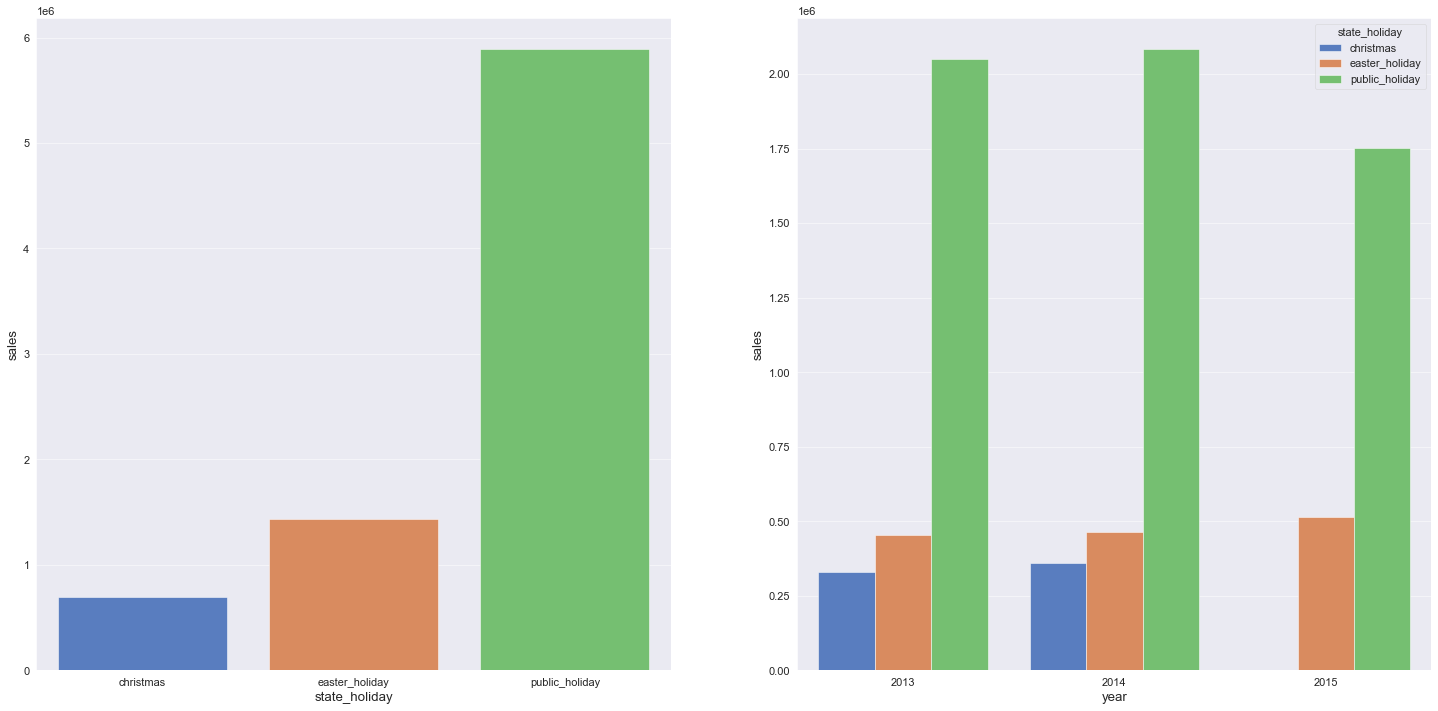

In [46]:
df_aux1 = df4[df4['state_holiday'] != 'regular_day']

# bar plot of sales per state_holiday
plt.subplot(1,2,1)
df_aux2 = df_aux1[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x = 'state_holiday', y = 'sales', data = df_aux2 );

# bar plot of sales per year and state_holiday
plt.subplot(1,2,2)
df_aux3 = df_aux1[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = df_aux3 );


### H8. Stores should sell more over the years.
* **FALSE** - Stores sell **less** over the years. (Note: There is no data from the whole year of 2015.)

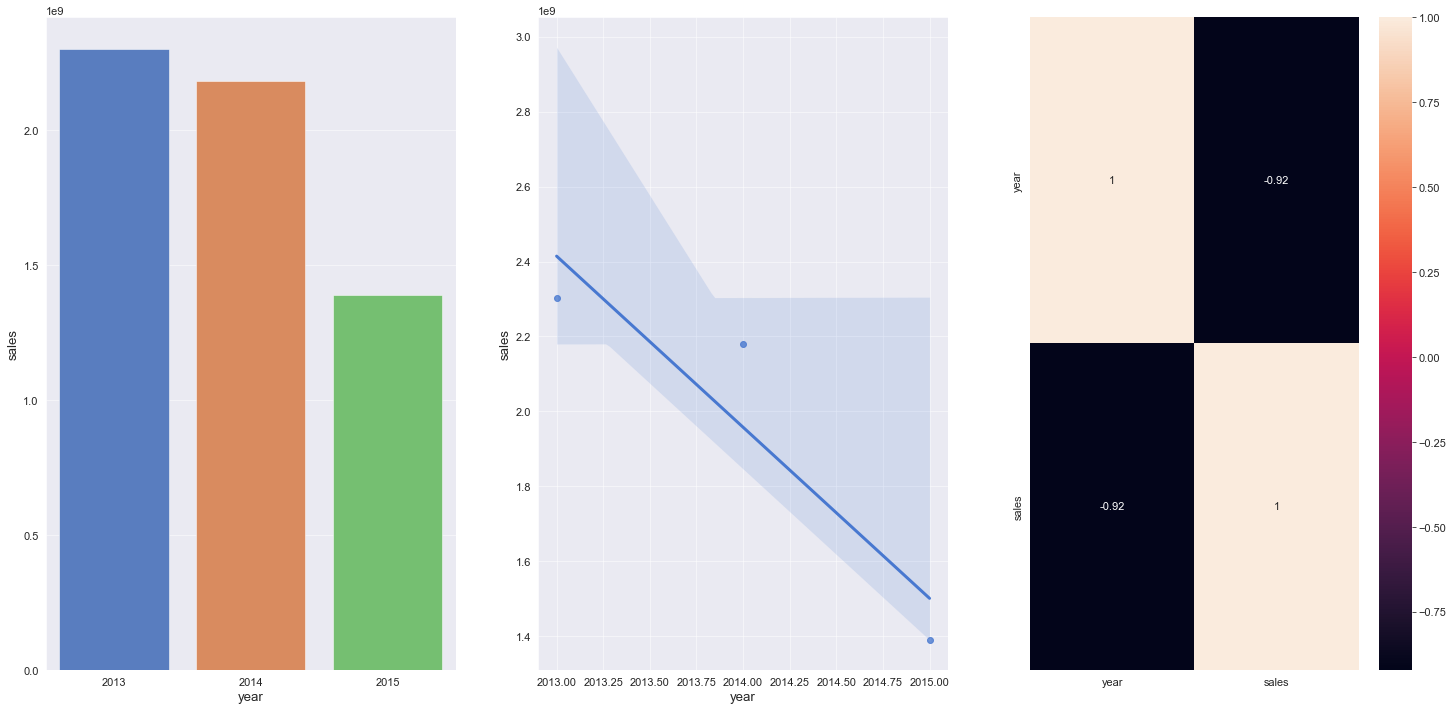

In [47]:
df_aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

# bar plot of sales per year
plt.subplot(1, 3, 1)
sns.barplot( x = 'year', y = 'sales' , data = df_aux1);

# reg plot of sales per year
plt.subplot(1, 3, 2)
sns.regplot( x = 'year', y = 'sales' , data = df_aux1);

# strength of the correlation between sales and year
plt.subplot(1, 3, 3)
sns.heatmap( df_aux1.corr( method = 'pearson'), annot = True);

### H9. Stores should sell more in the second semester of the year.
* **FALSE** - Stores sell **less** in the second semester of the year.

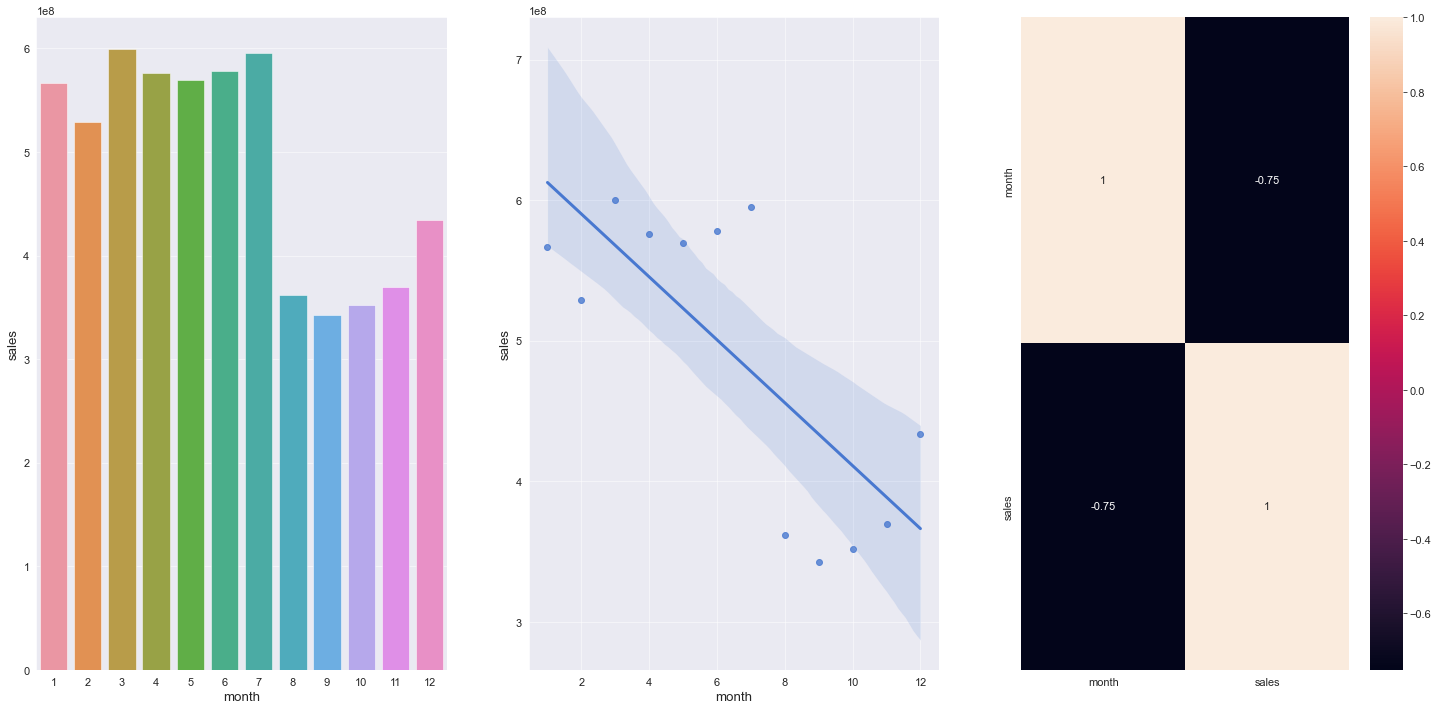

In [48]:
df_aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

# bar plot of sales per year
plt.subplot(1, 3, 1)
sns.barplot( x = 'month', y = 'sales' , data = df_aux1);

# reg plot of sales per year
plt.subplot(1, 3, 2)
sns.regplot( x = 'month', y = 'sales' , data = df_aux1);

# strength of the correlation between sales and year
plt.subplot(1, 3, 3)
sns.heatmap( df_aux1.corr( method = 'pearson'), annot = True);

### H10. Stores should sell more after the 10th day of each month.
* **TRUE** - Stores sell more after the 10th day of each month.

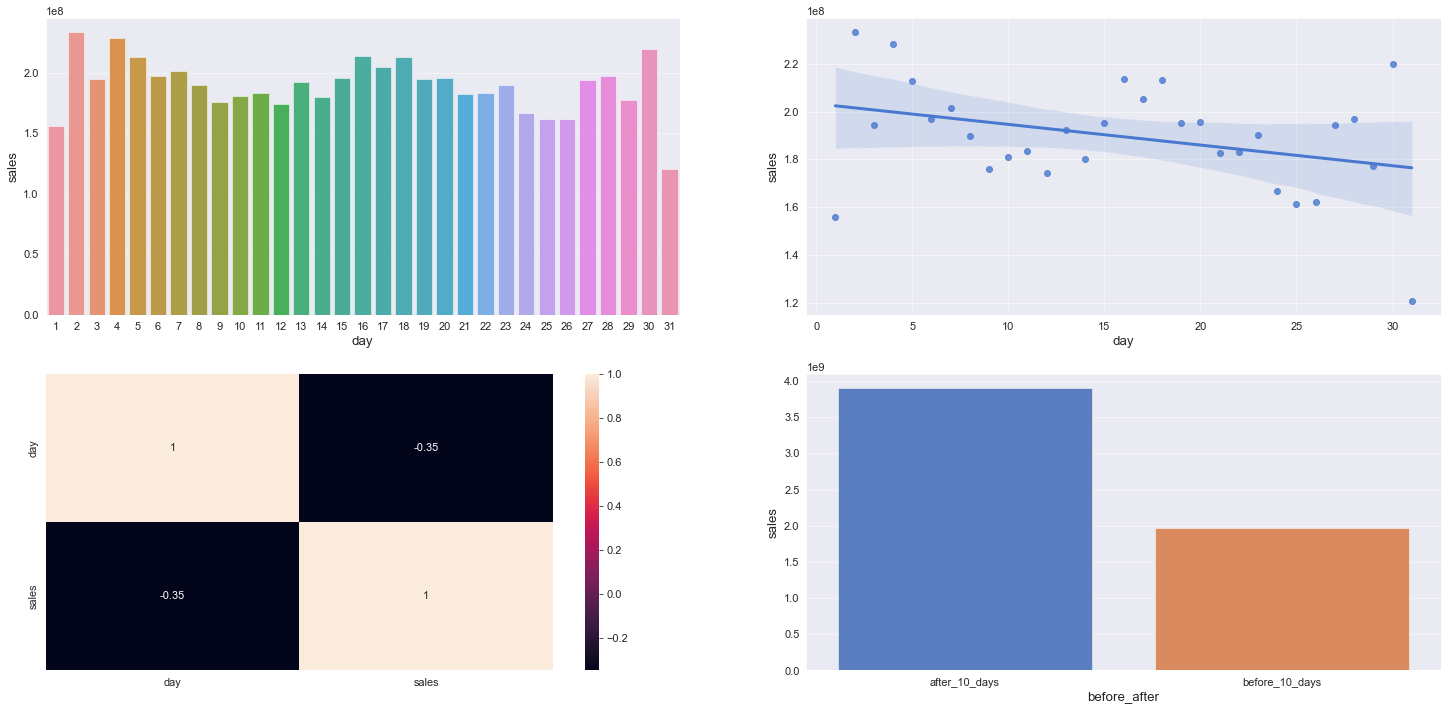

In [49]:
df_aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

# bar plot of sales per day
plt.subplot(2, 2, 1)
sns.barplot( x = 'day', y = 'sales' , data = df_aux1);

# reg plot of sales per day
plt.subplot(2, 2, 2)
sns.regplot( x = 'day', y = 'sales' , data = df_aux1);

# strength of the correlation between sales and day
plt.subplot(2, 2, 3)
sns.heatmap( df_aux1.corr( method = 'pearson'), annot = True);

# bar plot of sales before and after the 10th day of the month
plt.subplot(2, 2, 4)
df_aux1['before_after'] = df_aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
df_aux2 = df_aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = df_aux2 );

### H11. Stores should sell less on weekends.
* **TRUE** -  Stores sell less on weekends.

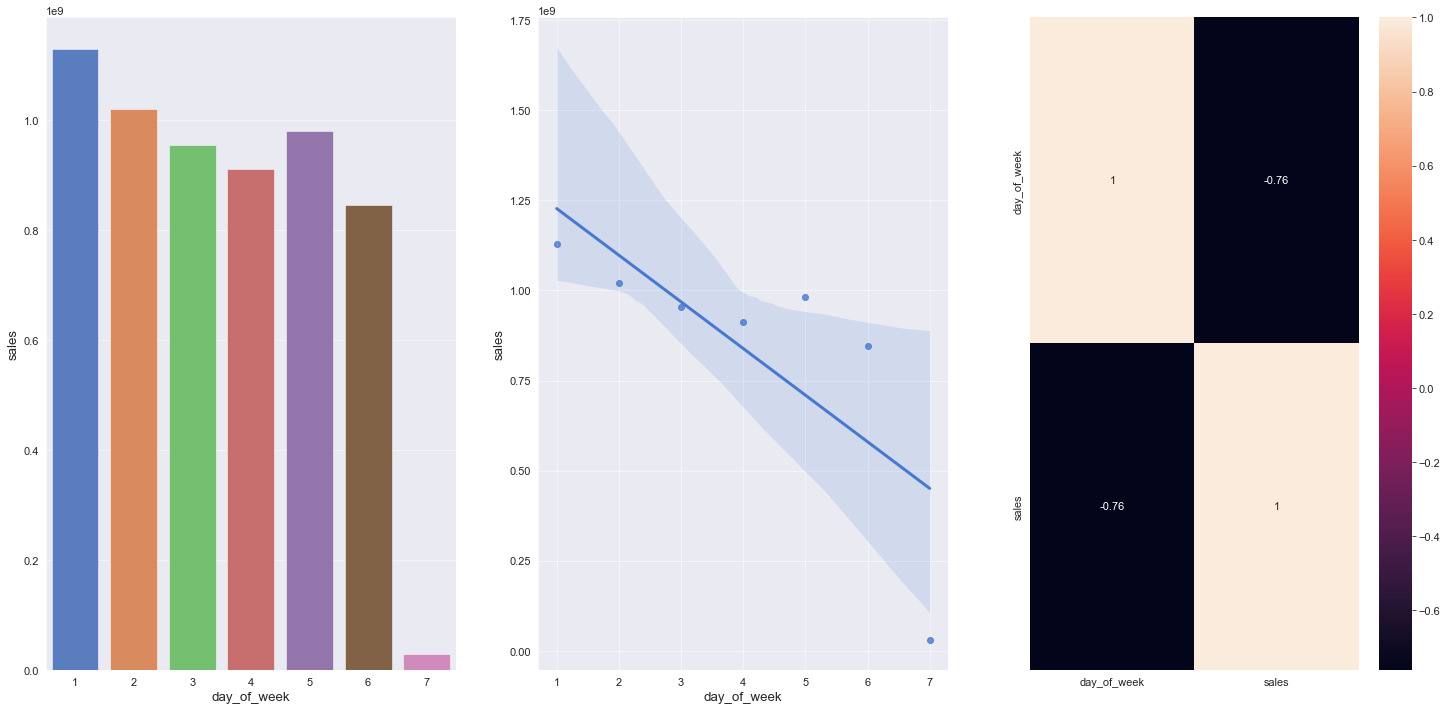

In [50]:
df_aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

# bar plot of sales per day_of_week
plt.subplot(1, 3, 1)
sns.barplot( x = 'day_of_week', y = 'sales' , data = df_aux1);

# reg plot of sales per day_of_week
plt.subplot(1, 3, 2)
sns.regplot( x = 'day_of_week', y = 'sales' , data = df_aux1);

# strength of the correlation between sales and day_of_week
plt.subplot(1, 3, 3)
sns.heatmap( df_aux1.corr( method = 'pearson'), annot = True);

### H12. Stores should sell less during school holidays.
* **TRUE** - Stores sell **less** during school holidays, except in July and August.

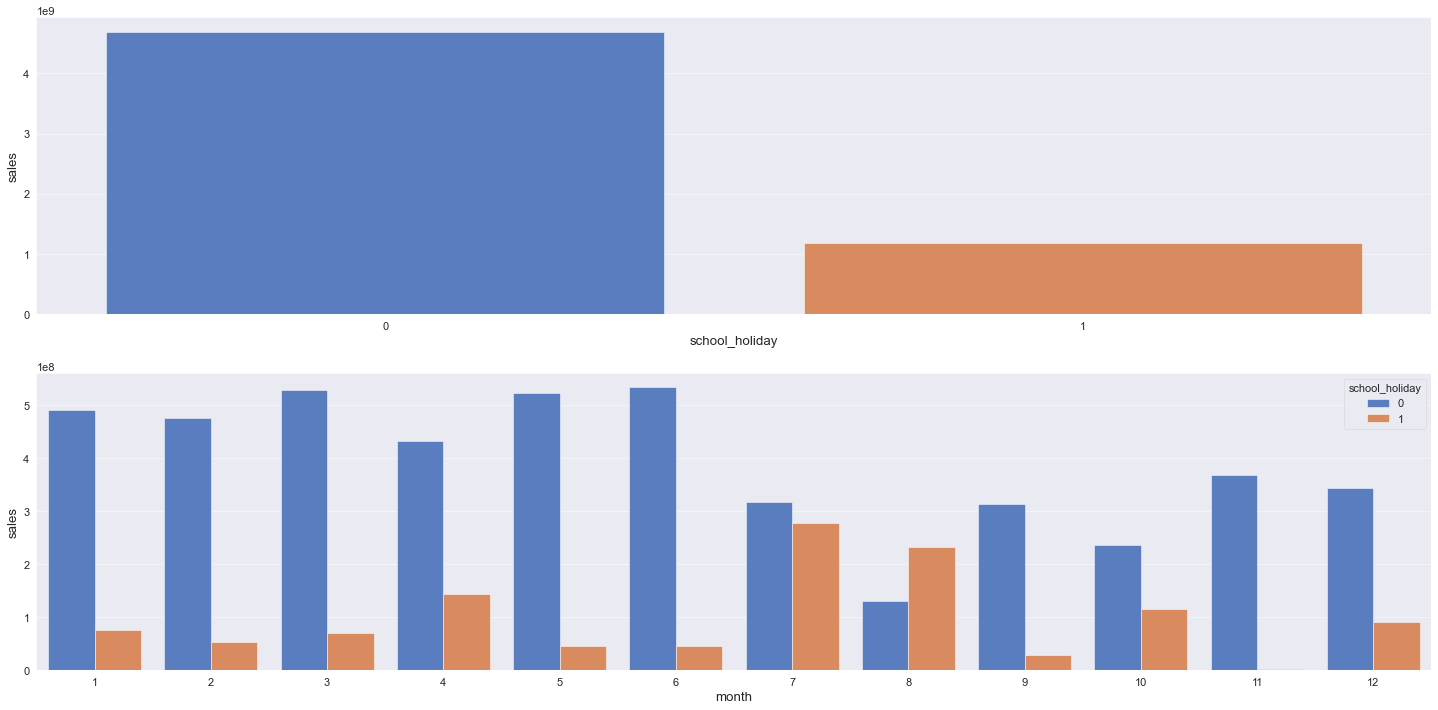

In [51]:
# bar plot of sales per school_holiday
plt.subplot(2, 1, 1)
df_aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales',  data = df_aux1);

# bar plot of sales per month and school_holiday
plt.subplot(2, 1, 2)
df_aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x = 'month', y = 'sales',  hue = 'school_holiday', data = df_aux2);

### 5.2.1. Hypothesis Summary

In [52]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']]

print( tabulate( tab, headers = 'firstrow' ) )

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 5.3. Multivariate Analysis

### 5.3.1. Numerical Attributes

* To do the correlation for numerical attributes we use the Pearson method.

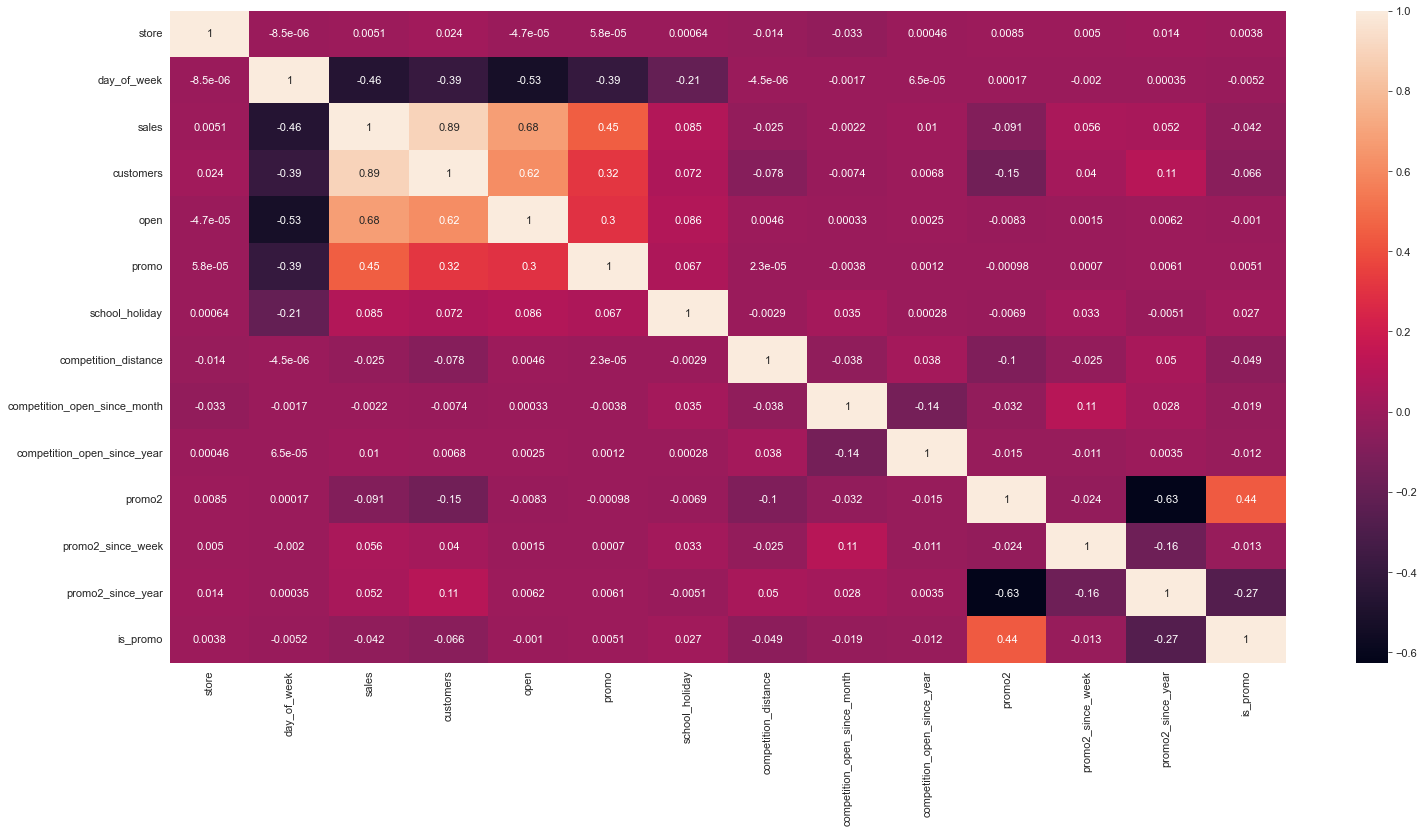

In [53]:
# strength of the correlation between numerical attributes
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

* The attributes with the highest correlations with 'sales' are as follows: "day_of_week", "customers", "open" and "promo". But the 'customers' attribute can't be used, because we don't have this information for the next 42 days to make the sales prediction.

### 5.3.2. Categorical Attributes

* To do the correlation for categorical attributes we use the Cramer's V method.
    * Cramer's V has values between 0 and 1, because there is no negative correlation for categorical attributes.
    * We have to use a slightly different formula for Cramer's V to correct the bias, because this method can be a heavily biased estimator and will tend to overstimate the strenght of association.

In [54]:
# get only catgorical attributes
df_aux = df4.select_dtypes( include = 'object' )
df_aux.head(5)

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


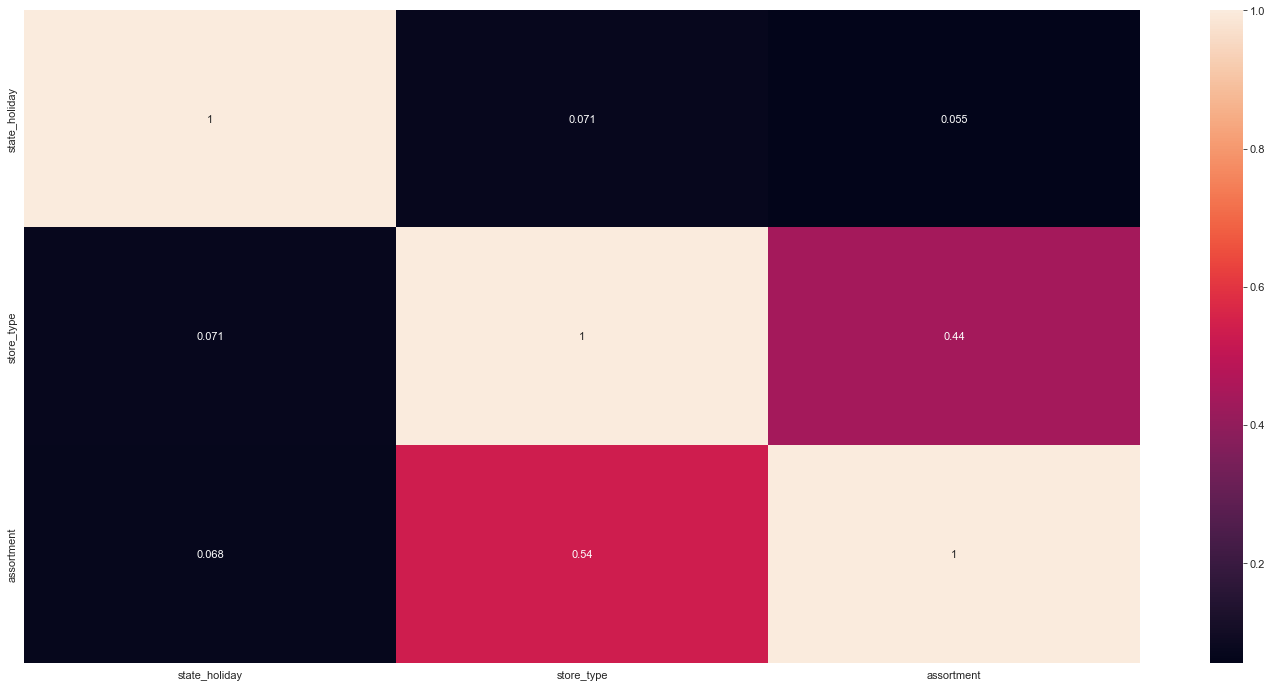

In [55]:
# Cramer's V for attributes pairs
df_aux1 = cramer_v(df_aux['state_holiday'], df_aux['state_holiday'])
df_aux2 = cramer_v(df_aux['state_holiday'], df_aux['store_type'])
df_aux3 = cramer_v(df_aux['state_holiday'], df_aux['assortment'])

df_aux4 = cramer_v(df_aux['store_type'], df_aux['state_holiday'])
df_aux5 = cramer_v(df_aux['store_type'], df_aux['store_type'])
df_aux6 = cramer_v(df_aux['store_type'], df_aux['assortment'])

df_aux7 = cramer_v(df_aux['assortment'], df_aux['state_holiday'])
df_aux8 = cramer_v(df_aux['assortment'], df_aux['store_type'])
df_aux9 = cramer_v(df_aux['assortment'], df_aux['assortment'])

df_corr = pd.DataFrame( {'state_holiday': [df_aux1, df_aux2, df_aux3],
              'store_type': [df_aux4, df_aux5, df_aux6],
              'assortment': [df_aux7, df_aux8, df_aux9] })

# strength of the correlation between categorical attributes
df_corr = df_corr.set_index( df_corr.columns )
sns.heatmap( df_corr, annot = True );

# 6. Data Preparation

* "The learning of most ML algorithms is facilitated with numerical data with the same scale."
* Data preparation types:
    * **Normalization:** rescale the center to 0 with standard deviation equals to 1.
    * **Rescaling:** rescale data to interval [0,1].
    * **Transformation:** categorical attributes to numerical attributes (encoding) or nature transformation (example: turn month feature to cyclic data).

In [98]:
df5 = df4.copy()

## 6.1. Normalization

* There is no numerical variables with a normal distribution, as we saw in the EDA. So, we are not going to do a normalization.

## 6.2. Rescaling

* Features with a few outliers will be rescaled using Min-Max Scaler (Very sensitive to outliers).
* Features with many ouliers will be rescaled using Robust Scaler.

In [57]:
# select only numerical features
df_aux1 = df5.select_dtypes( include = [ int , 'float64'] )
df_aux1.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


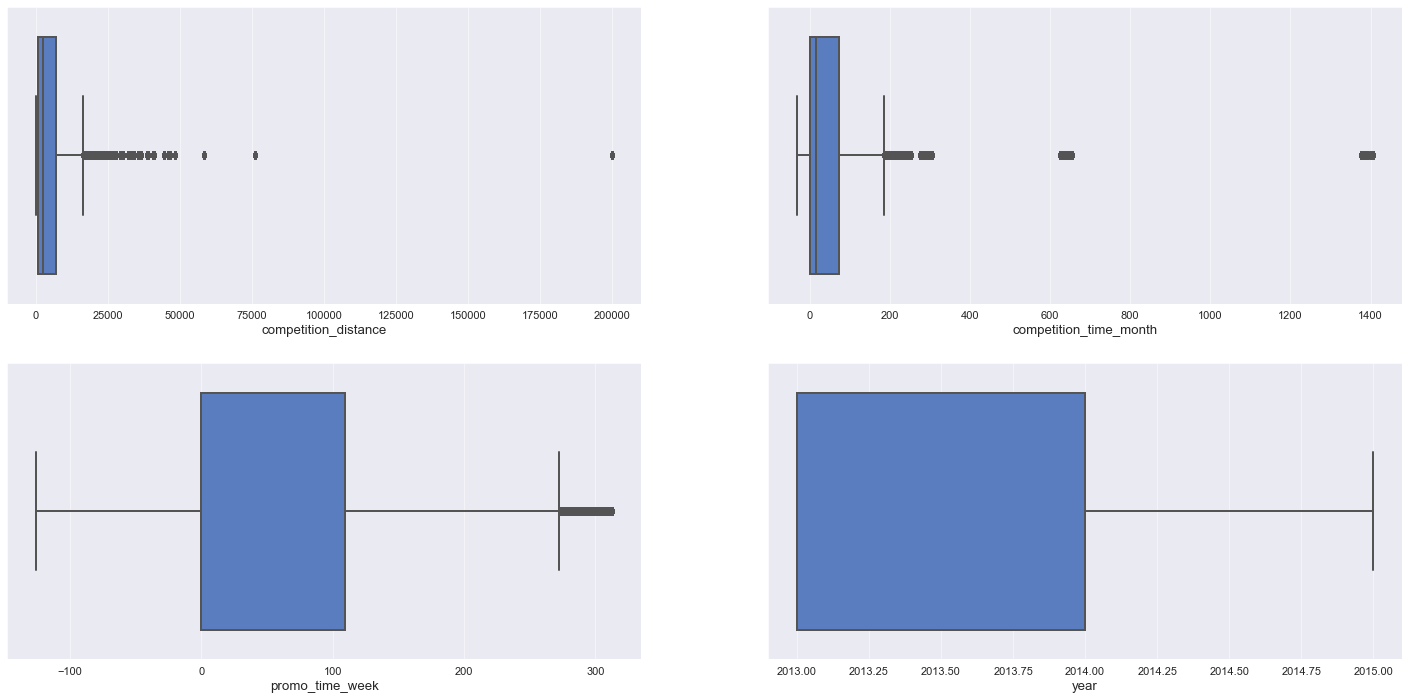

In [58]:
# boxplots for the numerical features
plt.subplot(2,2,1)
sns.boxplot( df5['competition_distance'] );

plt.subplot(2,2,2)
sns.boxplot( df5['competition_time_month'] );

plt.subplot(2,2,3)
sns.boxplot( df5['promo_time_week'] );

plt.subplot(2,2,4)
sns.boxplot( df5['year'] );

In [100]:
rs = RobustScaler()
mms = MinMaxScaler()

# Applying Robust Scaler to competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# Applying Robust Scaler to competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb' ) )

# Applying Min-Max Scaler to promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# Applying Min-Max Scaler to year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

## 6.3. Transformation

### 6.3.1. Enconding

* Enconding types:
    * **One Hot Enconding:** create a column for each unique value of the attribute and fill the fields with 0 or 1.
    * **Label Enconding:** replace each unique value for a number.
    * **Ordinal Encondig:** replace each unique value for a number keeping an order that indicates an intensity.
    * **Target Enconding:** replace each unique value by the average of the target per that value.
    * **Frequency Enconding:** replace each unique value by the frequency that the value appears. 
    * **Embedding Encondig:** replace each unique value for another value that mantains the feature distance in an context. (Used in NLP)

In [99]:
# Applying One Hot Enconding to state_holiday
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# Applyng Label Enconding to store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ) )

# Applyng Ordinal Enconding to assortment
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

# check
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1


### 6.3.2 Response Variable Transformation

* Transformation types:
    * **Logarithm Transformation**
    * **Box-Cox Transformation**
    * **Cube-Root Transformation**
    * **Square-Root Transformation**
    * **Sine and Cosine Transformation**

The main goal with these transformations is to approximate the distribution to a normal distribution.

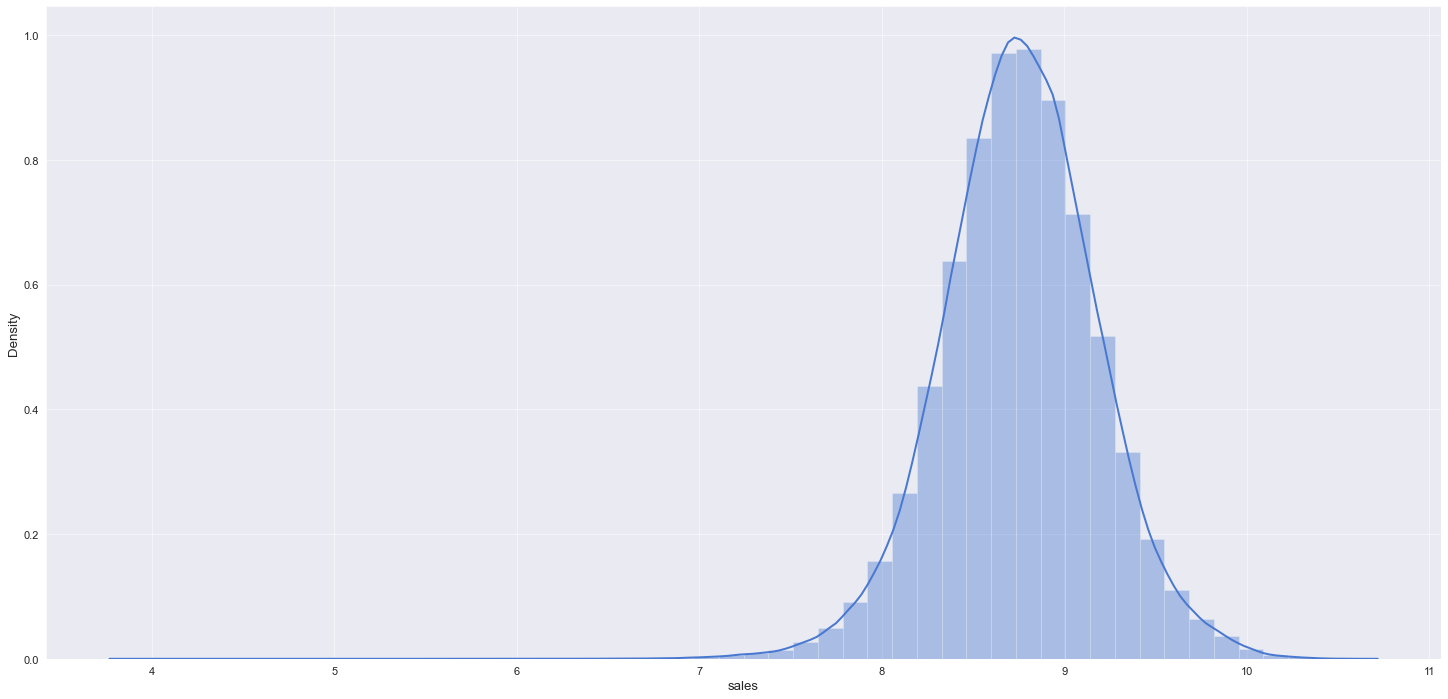

In [61]:
# Apllying Logarithm Transformation to sales
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot( df5['sales'] );

### 6.3.3 Nature Transformation

* We have show the real nature of the feature with this transformation. 
    * **For example:** the months has a cycle that repeats every year. This cycle can be represented by a circle and each month by an angle with its sin and cos.

In [62]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# check
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984


# 7. Feature Selection

* Feature selection methods:
    * Filter Methods.
    * Embedded Methods.
    * Wrapper Methods.

In [63]:
df6 = df5.copy()

In [64]:
# remove features that were used to create another features 
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis = 1 )

## 7.1. Split Dataframe Into Training and Test Dataset

* Since the project's goal is to predict sales for the next 6 weeks, then the test data will be the last 6 weeks of the dataset and the training data will be the rest.

In [65]:
# get the first day of the test data
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [66]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min/Max Date: {} / {}'.format( X_train['date'].min() ,  X_train['date'].max()) )
print( 'Test Min/Max Date: {} / {}'.format( X_test['date'].min(), X_test['date'].max() ) )

Training Min/Max Date: 2013-01-01 00:00:00 / 2015-06-18 00:00:00
Test Min/Max Date: 2015-06-19 00:00:00 / 2015-07-31 00:00:00


## 7.2. Boruta as Feature Selector

In [67]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs = -1 )

# define Boruta (Activate to run Boruta)
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train_n, y_train_n )

### 7.2.1 Best Features from Boruta

In [68]:
##(Activate after run Boruta)
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 ) 
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [69]:
## features selected by boruta
#cols_selected_boruta

## 7.3. Manual Feature Selection

* It's important to compare the features Boratura selected and those we considered as high relevant in the EDA.
* We can remove or add more features to the Boruta's selection.

In [70]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_cos',
    'month_sin',        ## added
    'day_sin',
    'day_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'week_of_year_cos',
    'week_of_year_sin'  ## added
]

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full =  cols_selected_boruta + feat_to_add

# 8. Machine Learning Model

Five machine learning models will be used for performance comparasion:

* Baseline Model
    * Average Model
* Linear Models
    * Linear Regression
    * Linear Regression Regularized (Lasso)
* Non-linear Models
    * Random Forest Regressor
    * XGBoost Regressor

In [71]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 8.1. Average Model

In [72]:
df_aux1 = x_test.copy()
df_aux1['sales'] = y_test.copy()

# prediction
df_aux2 = df_aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales':'predictions'} )
df_aux1 = pd.merge( df_aux1, df_aux2, how = 'left', on = 'store')
yhat_baseline = df_aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 8.2. Linear Regression Model

In [73]:
# model
lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( "Linear Regression", np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 8.2.1 Linear Regression Model - Cross Validation

In [74]:
lr_result_cv = cross_validation( x_training, 5, "Linear Regression", lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 8.3. Linear Regression Regularized Model (Lasso)

In [75]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( "Linear Regression - Lasso", np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 8.3.1 Lasso - Cross Validation

In [76]:
lrr_result_cv = cross_validation( x_training, 5, "Linear Regression - Lasso", lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 8.4. Random Forest Regressor

In [77]:
## model
#rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

# prediction
#yhat_rf = rf.predict( x_test )

# performance
#rf_result = ml_error( "Random Forest Regressor", np.expm1( y_test ), np.expm1( yhat_rf ) )
#rf_result

### 8.4.1 Random Forest Regressor - Cross Validation

In [78]:
#rf_result_cv = cross_validation( x_training, 5, "Random Forest Regressor ", rf, verbose=True )
#rf_result_cv

## 8.5. XGBoost Regressor

In [79]:
# model
#model_xgb = []
#model_xgb = xgb.XGBRegressor().fit( x_train, y_train )

# prediction
#yhat_xgb = model_xgb.predict( x_test )

# performance
#xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
#xgb_result

### 8.5.1 XGBoost Regressor - Cross Validation

In [80]:
#xgb_result_cv = cross_validation( x_training, 5, "XGBoost Regressor ", model_xgb, verbose=True )
#xgb_result_cv

## 8.6. Compare Model's Performance

### 8.6.1. Single Performance

In [81]:
#modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
#modelling_result.sort_values( 'RMSE' )

### 8.6.2. Real Performance - Cross Validation

In [82]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
#modelling_result_cv

* The best two models according to the results for the cross validation are Random Forest Regressor and XGBoost Regressor.
* The XGBoost Regressor has been choseen to be the model for the next steps, because it's a lighter model than the Random Forest and It gives good results too.

# 9. Hyperparameter Fine Tunning

Strategies to fine tuning:

* **Random Search**
    * Set values for each hyperparameter randomly according to a given list of possible values. 
* **Grid Search** 
    * Set every possible values combination for the hyperparameters according to a given list of possible values.
* **Bayesian Search**
    * Set values for each hyperparameter using Bayes theory according to the previous values.  

These estrategies uses metrics to evaluate the performance and choose the best parameters, like cross-validation.

## 9.1. Random Search

In [83]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [84]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose
#    hp = { k: sample( v, 1 )[0] for k, v in param.items()} 
#    print( hp )
#
#
#    # model
#    model_xgb = xgb.XGBRegressor(   objective='reg:squarederror',
#                                    n_estimators=hp['n_estimators'],
#                                    eta=hp['eta'],
#                                    max_depth=hp['max_depth'],
#                                    subsample=hp['subsample'],
#                                    colsample_bytree=hp['colsample_bytree'],
#                                    min_child_weight=hp['min_child_weight']
#                                )
#                                
#    # performance
#    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb,  verbose=False)
#    final_result = pd.concat( [final_result, result] )

#final_result

## 9.2. Final Model

In [85]:
## model
#model_xgb_tuned = xgb.XGBRegressor(
#                                    objective='reg:squarederror',
#                                    n_estimators=3000,
#                                    eta=0.03,
#                                    max_depth=5,
#                                    subsample=0.7,
#                                    colsample_bytree=0.7,
#                                    min_child_weight=3
#                                ).fit( x_train, y_train )
#
## prediction
#yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
#xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
#xgb_result_tuned

In [86]:
# saving model
#with open('./model/model_rossmann.pickle', 'wb') as file:
#    pickle.dump(model_xgb_tuned, file)

In [87]:
# loading model
with open('./model/model_rossmann.pickle', 'rb') as file:
    model_xgb_tuned = pickle.load(file)

# predict and performance
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

# 10. Error Interpretation (Regression)

Error metrics characteristics:
* **MAE** (Mean Absolute Error)
    * It assigns equal weight to all errors;
    * It is robust in the presence of Outliers;
    * It is easy to understand by the business team.
* **MAPE** (Mean Absolute Percentage Error)
    * It shows how far the prediction is from the actual value, on average, as a percentage;
    * It is vastly used to report results;
    * It can't be used if the response variable contains zero.
* **RMSE** (Root Mean Squared Error)
    * It assigns bigger weights to bigger errors;
    * It is sensitive in the presence of Outliers;
    * It is ideal for measuring the performance of machine learning models.
* **MPE** (Mean Percentage Error) 
    * It can't be used to evaluate model's performance;
    * It is useful for understanding if the model is understimating or overestimating values;
    * It can't be used if the response variable contains zero. 

In [88]:
df9 = X_test[ cols_selected_boruta_full ].copy()

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 10.1. Business Performance

Strategies to present the model's performance:

* **Comparison to status quo**
    * Comparing the performance to an existing model.
* **Revenue Increase**
    * Presenting the performance in terms of revenue increase.

In [89]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={ 0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={ 0:'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [90]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
861,862,314428.187500,313785.383261,315070.991739,642.804239,0.080597
906,907,258958.640625,258316.720796,259600.560454,641.919829,0.102000
313,314,197481.218750,196903.420615,198059.016885,577.798135,0.120327
737,738,307843.062500,307110.143066,308575.981934,732.919434,0.084622


* Some stores are difficult to predict the revenue (Those with high MAPE).

In [91]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106616.007812,103241.971384,109990.044241,3374.036428,0.591074
908,909,221679.656250,213805.026028,229554.286472,7874.630222,0.517480
875,876,196043.031250,191954.240776,200131.821724,4088.790474,0.333636
169,170,200607.265625,199292.258505,201922.272745,1315.007120,0.325416
901,902,192626.078125,191417.481590,193834.674660,1208.596535,0.301989


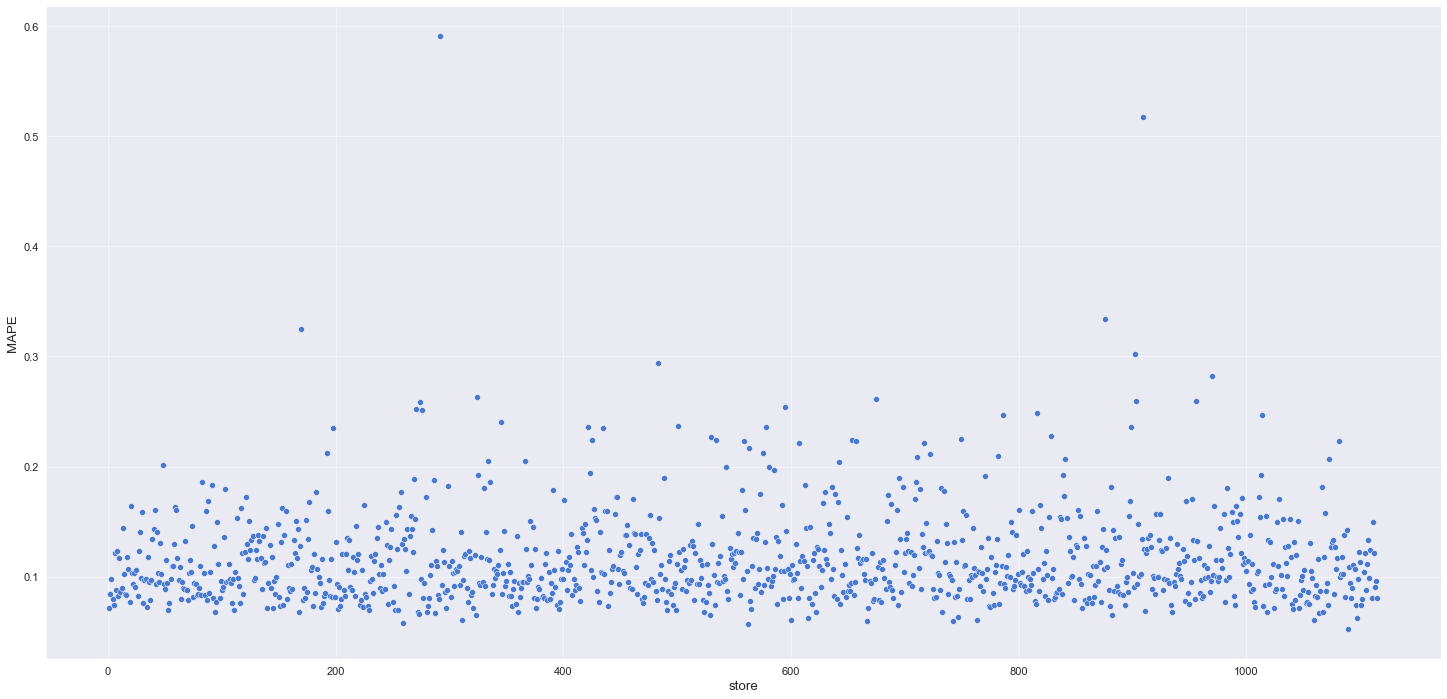

In [92]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

## 10.2. Total Performance

In [93]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0).reset_index().rename( columns={ "index": "Scenario", 0:"Values" } )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$286,213,120.00"
1,worst_scenario,"R$285,356,444.01"
2,best_scenario,"R$287,069,822.32"


## 10.3. Machine Learning Performance

In [94]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

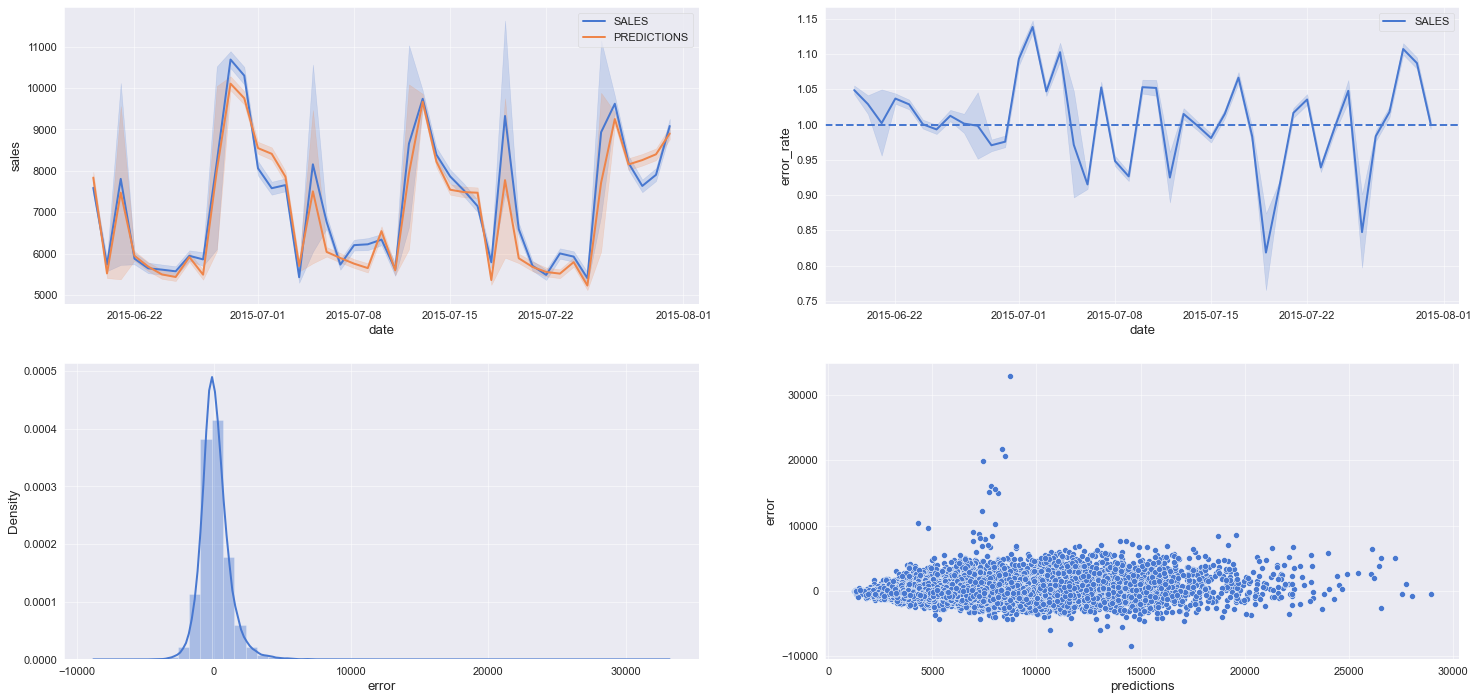

In [95]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9, label='SALES' )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );

* The top left plot shows the model's predictions are close to the real values, with some spikes;
* The top right plot shows the model's predictions have a certain variance around the real values (understimating and overestimating); 
* The bottom left plot shows the error distribution is close to a normal distribution, wich is a good result for a regression.
* The bottom right plot shows the residuals for the predictions and most of it are in a range between -10000 and 100000, forming a tube, wich is a good result. (Residual analysis).

# 11. Deploy Model to Production

## 11.1. Rossman Class

In [102]:
class Rossman( object ):

    def __init__( self ):
        self.competition_distance_scaler   = pickle.load( open( 'parameter/competition_distance_scaler.pkl', 'rb' ) )                
        self.competition_time_month_scaler = pickle.load( open( 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( 'parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( 'parameter/store_type_scaler.pkl', 'rb' ) )


    def data_cleaning( self, df1 ):
        ## 2.1. Rename Columns
        cols_old = df1.columns
        snake_case = lambda x: inflection.underscore(x)
        cols_new = list( map(snake_case, cols_old) )

        # rename columns
        df1.columns = cols_new
    
        ## 2.3. Data Types
        # changing date to datetime type
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 2.5. Fillout NA
        # competition_distance  
        df1['competition_distance'].fillna(200000, inplace = True)
        
        # competition_open_since_year and competition_open_since_month
        df1['competition_open_since_year'].fillna( df1['date'].dt.year, inplace = True)
        df1['competition_open_since_month'].fillna( df1['date'].dt.month, inplace = True)
        
        # promo2_since_year and promo2_since_week
        df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)
        df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week, inplace = True)
        
        # promo_interval
        df1['promo_interval'].fillna(0, inplace = True)

        # month map to help the operation
        month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 
                    10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else (1 if x['month_map'] in x['promo_interval'].split( "," ) else 0), axis = 1)
        
        ## 2.6. Change Data Types
        # competition data to int
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo data to int
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1
    

    def feature_engineering( self, df2 ): 
        # year
        df2['year'] = df2['date'].dt.year

        # month 
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2['competition_since'] = df2.apply(lambda x: 
            datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)

        # competition time month
        df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

        # promo time week
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        assortment = {'a' : 'basic', 'b' : 'extra', 'c' : 'extended'}
        df2['assortment'] = df2['assortment'].map(assortment)

        # state holiday       
        state_holiday = {'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'}
        df2['state_holiday'] = df2['state_holiday'].map(state_holiday)

        ## 4.1. Rows Filtering
        df2 = df2[ (df2["open"] != 0) & (df2["sales"] > 0) ]
        
        ## 4.2. Columns Selection
        df2.drop( columns = ['customers', 'open', 'promo_interval', 'month_map'], axis = 1, inplace = True )


    def data_preparation( self, df5 ):
        ## 6.2. Rescaling

        # Applying Robust Scaler to competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # Applying Robust Scaler to competition time month
        df5['competition_time_month'] =  self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # Applying Min-Max Scaler to promo time week
        df5['promo_time_week'] =  self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )

        # Applying Min-Max Scaler to year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 6.3.1. Enconding
        # Applying One Hot Enconding to state_holiday
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # Applyng Label Enconding to store_type
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # Applyng Ordinal Enconding to assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 6.3.3 Nature Transformation
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance','competition_open_since_month',
            'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
            'month_cos','month_sin', 'day_sin','day_cos','day_of_week_sin','day_of_week_cos','week_of_year_cos','week_of_year_sin'  
        ]

        return df5[ cols_selected ]

## 11.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import request, Response
from rossmann.Rossmann import Rossmann


# loading model
model = pickle.load( open('../model/model_rossmann.pkl', 'rb' ) )

# Initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ):  # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else:                              # multiple examples 
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann class
        pipeline = Rossman()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response


    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 11.3. API Tester